In [3]:
import numpy as np
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dropout,LSTM,Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import datetime

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
import gc
import math
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import os
import numpy as np

### 获取所有配对数据

In [4]:
pairdata=pd.read_csv('../twice/315/pairdata.csv')

### 获取全网进站时序

In [5]:
def getAllStations(pairdata):
    
    return list(set(pairdata.IN_CODE))

In [6]:
def time2seconds(time):
    hours=int(str(time)[:-4])
    minutes=int(str(time)[-4:-2])
    seconds=int(str(time)[-2:])
    
    return hours*60*60+minutes*60+seconds

In [7]:
def get_in_sequence(row):
    in_date=row['IN_DATE']
    in_time=row['IN_TIME']
    
    day=(in_date-1)%100
    single_sequence=math.floor((time2seconds(in_time)-time2seconds(62000))/(60*10))
    sequence=day*100+single_sequence
    
    return sequence

In [8]:
def peopleBySequenceStation(pairdata):
    result_map={}
    all_stations=sorted(getAllStations(pairdata))
    if len(all_stations) != 123:
        print('错误！全网进站数据不包含完整的车站')
    
    for station in all_stations:
        pairdataByStation=pairdata[pairdata['IN_CODE']==station]
        station_index=[]
        for seq in range(3000):
            station_index.append(len(pairdataByStation[pairdataByStation['IN_SEQUENCE']==seq]))
        result_map[station]=station_index
            
    before_result_df=pd.DataFrame(list(result_map.items()),columns=['CODE','SEQ'])
    for col in range(3000):
        before_result_df[str(col)]=list(seq[col] for seq in before_result_df.SEQ)
        
    return before_result_df

In [9]:
def getInSequence_All_Station(data):
    data['IN_SEQUENCE']=data.apply(lambda r:get_in_sequence(r),axis=1)
    
    in_seq=peopleBySequenceStation(data)
    return in_seq.drop('SEQ',axis=1)

In [10]:
in_seq=pd.read_csv('../paper/csv/all_in_seq_3000.csv')
in_seq=in_seq.set_index('CODE')
in_seq.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
CODE,,,,,,,,,,,,,,,,,,,,,
102,22,31,52,60,48,69,65,82,92,111,...,145,118,118,111,93,90,107,2,0,0
103,50,59,94,94,112,115,157,164,198,193,...,87,92,60,64,57,65,49,2,0,0
104,93,158,145,188,183,188,207,242,261,284,...,51,47,40,52,43,35,14,5,1,0
106,27,52,55,84,108,100,152,181,186,203,...,35,13,27,12,19,6,6,4,0,0
107,95,159,182,262,257,317,427,545,529,582,...,66,87,65,55,73,53,29,15,3,0


In [11]:
#in_seq.to_csv('../paper/img/all_in_seq_3000.csv')

### 对某一站点进站预测

In [14]:
def get_labels(in_seq_by_station,time_step=20):
    label=in_seq_by_station[700+1:]
    train_label=label[:20*100]
    test_label=label[20*100:]
    
    train_Y=train_label[20:]
    test_Y=test_label[20:]
    
    return np.array(train_Y),np.array(test_Y)

In [15]:
def get_block1(in_seq_by_station,time_step=20):
    data=in_seq_by_station[700:-1]
    data=data[:,np.newaxis]
    train_data=data[:20*100]
    test_data=data[20*100:]
    
    train_X=[]
    test_X=[]
    
    for i in range(len(train_data)-time_step):
        train_X.append(train_data[i:i+time_step].tolist())
        
    for i in range(len(test_data)-time_step):
        test_X.append(test_data[i:i+time_step].tolist())
    
    return np.array(train_X),np.array(test_X)

In [16]:
def get_block2(in_seq_by_station,time_step=20):
    fore_data=in_seq_by_station[1:-7*100]
    fore_data=fore_data[:,np.newaxis]
    last_data=in_seq_by_station[700:-1]
    last_data=last_data[:,np.newaxis]
    data=np.append(fore_data,last_data,axis=-1)
    
    train_data=data[:20*100]
    test_data=data[20*100:]
    
    train_X=[]
    test_X=[]
    
    for i in range(len(train_data)-time_step):
        train_X.append(train_data[i:i+time_step].tolist())
        
    for i in range(len(test_data)-time_step):
        test_X.append(test_data[i:i+time_step].tolist())
    
    return np.array(train_X),np.array(test_X)

In [17]:
def get_block2_split(in_seq_by_station,w1,w2,time_step=20):
    fore_data=in_seq_by_station[1:-7*100]*w1
    fore_data=fore_data[:,np.newaxis]
    last_data=in_seq_by_station[700:-1]*w2
    last_data=last_data[:,np.newaxis]
    data=np.append(fore_data,last_data,axis=-1)
    
    train_data=data[:20*100]
    test_data=data[20*100:]
    
    train_X=[]
    test_X=[]
    
    for i in range(len(train_data)-time_step):
        train_X.append(train_data[i:i+time_step].tolist())
        
    for i in range(len(test_data)-time_step):
        test_X.append(test_data[i:i+time_step].tolist())
    
    return np.array(train_X),np.array(test_X)

In [18]:
def get_block2_only_sanetime(in_seq_by_station,time_step=20):
    data=in_seq_by_station[1:-7*100]
    data=data[:,np.newaxis]
    train_data=data[:20*100]
    test_data=data[20*100:]
    
    train_X=[]
    test_X=[]
    
    for i in range(len(train_data)-time_step):
        train_X.append(train_data[i:i+time_step].tolist())
        
    for i in range(len(test_data)-time_step):
        test_X.append(test_data[i:i+time_step].tolist())
    
    return np.array(train_X),np.array(test_X)

In [19]:
def build_model_with_sametime(): 
    _input=Input((20,2))
    
    X=Dense(50)(_input)  
    X=layers.recurrent.LSTM(100)(X) #1 (?,100) 
    X=layers.Dropout(0.2)(X)
    X=Dense(20)(X) #(?,20)
    
    result=Dense(1)(X) 
    
    model = Model(inputs = _input, outputs = result)
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    
    return model

In [20]:
def build_model(): 
    block1_input=Input((20,1))
    block2_input=Input((20,2))
    
    X=Dense(50)(block1_input)   
    X=layers.recurrent.LSTM(100)(X) #1 (?,100)   
    X=layers.Dropout(0.2)(X)
    block1_result=Dense(20)(X) #(?,20)
    
    #[早期进站，后期进站]->进站序列
    block1_result_input=layers.core.Reshape((-1,1))(block1_result)
    block2_X=layers.Concatenate(axis=-1)([block1_result_input,block2_input]) #(?,20,3)
    X=Dense(50)(block2_X)   
    X=layers.recurrent.LSTM(100)(X) #1 (?,100)   
    X=layers.Dropout(0.2)(X)
    block2_result=Dense(20)(X) #(?,20)
    
    final_result=layers.Average()([block1_result,block2_result])
    final_result=Dense(1)(final_result)
    
    model = Model(inputs = [block1_input,block2_input], outputs = final_result)
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
                                                              
    return model

In [21]:
def build_single_model():
    block1_input=Input((20,1))
    
    X=Dense(50)(block1_input)   
    X=layers.recurrent.LSTM(100)(X) #1 (?,100)   
    X=layers.Dropout(0.2)(X)
    X=Dense(20)(X) #(?,20)
    
    result=Dense(1)(X)
    
    model = Model(inputs = block1_input, outputs = result)
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
                                                              
    return model

In [31]:
def eva_resnet(block1,block2,test_Y,out_list,model):
    sum_rmse=0
    sum_max=0
    sum_mae=0
    for i in range(100):
        result=np.round(np.array(flat(model.predict([block1,block2])))*np.std(out_list)+np.mean(out_list))
        labels=test_Y*np.std(out_list)+np.mean(out_list)
        sum_rmse+=np.sqrt(np.average((result - labels) ** 2))
        sum_max+=max(result-labels)
        sum_mae+=np.average(np.abs(result - labels))
            
    
    print('rmse:',sum_rmse/100)
    print('max',sum_max/100)
    print('mae',sum_mae/100)
    
    return sum_rmse/100,sum_max/100,sum_mae/100

In [32]:
def eva(test_X_lstm_out,test_Y,out_list,model):
    sum_rmse=0
    sum_max=0
    sum_mae=0
    for i in range(100):
        result=np.round(np.array(flat(model.predict(test_X_lstm_out)))*np.std(out_list)+np.mean(out_list))
        labels=test_Y*np.std(out_list)+np.mean(out_list)
        sum_rmse+=np.sqrt(np.average((result - labels) ** 2))
        sum_max+=max(result-labels)
        sum_mae+=np.average(np.abs(result - labels))
            
    
    print('rmse:',sum_rmse/100)
    print('max',sum_max/100)
    print('mae',sum_mae/100)
    
    return sum_rmse/100,sum_max/100,sum_mae/100

In [23]:
def evaluate(result,labels,target_station,isSingle):
    acc_num=0
    count=0
    for i in range(len(result)):
        if labels[i]>0:
            acc_num+=np.abs(labels[i]-result[i])/labels[i]
            count+=1
    acc=1-(acc_num/count) #准确率百分比
    average = np.average(np.abs(result - labels)) #绝对平均误差
    max = np.max(np.abs(result - labels)) #误差最大值
    RMSE = np.sqrt(np.average((result - labels) ** 2)) #均方根误差
    
    print('误差最大值：', max)
    print('绝对平均误差：', average)
    print('均方根误差：', RMSE)
    print('准确率百分比', acc)
    
    
    plt.figure(figsize=(20,6))
    plt.plot(list(range(len(result))), list(result), color='R')
    plt.plot(list(range(len(labels))), list(labels), color='G')
    if isSingle==1:        
        plt.savefig('img_in/'+str(target_station)+'_Single.jpg')
        with open('in_data/'+str(target_station)+'_Single.pkl','wb') as f:
            pickle.dump([max,average,RMSE,acc],f)
    else:
        plt.savefig('img_in/'+str(target_station)+'_Resnet.jpg')
        with open('in_data/'+str(target_station)+'_Resnet.pkl','wb') as f:
            pickle.dump([max,average,RMSE,acc],f)
    plt.show()
    
    return max,average,RMSE,acc

In [24]:
def compare_img(target_station,obj0,obj1):
    plt.figure(figsize=(10,6))
    
    x_names=['max_mis','avg_mis','RMSE','acc']
    index=np.arange(4)
    bar_width=0.3
    m1=plt.bar(index-bar_width/2,obj0,bar_width,color='b',label='ResNet')
    m2=plt.bar(index+bar_width/2,obj1,bar_width,color='r',label='SingleLSTM')
    plt.legend()
    
    plt.xticks(index, x_names)
    
    # 添加数据标签
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width() / 2, height, height, ha='center', va='bottom')
            # 柱形图边缘用白色填充，纯粹为了美观
            rect.set_edgecolor('white')
    
    add_labels(m1)
    add_labels(m2)
    plt.savefig('img_in/'+str(target_station)+'_compare.jpg')
    plt.show()

In [25]:
def flat(seq):
    start=seq[0].tolist()
    for i in range(1,len(seq)):
        start.append(seq[i][-1])
    
    return start

In [26]:
def save_file(path,file):
    with open(path,'wb') as f:
        pickle.dump(file,f)

In [27]:
def load_file(path):
    with open(path,'rb') as f:
        file=pickle.load(f)
    
    return file

In [28]:
def different_percent_sametime(target_station,in_seq):
    in_seq_by_station=in_seq.loc[target_station].tolist()
    
    in_seq_by_station_norm=(in_seq_by_station-np.mean(in_seq_by_station))/np.std(in_seq_by_station)
    
    train_Y,test_Y=get_labels(in_seq_by_station_norm)
    
    rmse=[]
    _max=[]
    mae=[]
    
    #仅含有历史同期数据
    train_X,test_X=get_block2_only_sanetime(in_seq_by_station_norm)
    model=build_single_model()
    model.reset_states()
    model.fit(train_X,train_Y,batch_size=50,nb_epoch=500,validation_split=0.05)
    rmse1,max1,mae1=eva(test_X,test_Y,in_seq_by_station,model)
    rmse.append(rmse1)
    _max.append(max1)
    mae.append(mae1)
    
    #不同比例
    for w1 in range(10,100,10):
        train_X,test_X=get_block2_split(in_seq_by_station_norm,1-w1/100,w1/100)
        model = build_model_with_sametime()
        model.reset_states()
        model.fit(train_X,train_Y,batch_size=50,nb_epoch=500,validation_split=0.05)
        rmse1,max1,mae1=eva(test_X,test_Y,in_seq_by_station,model)
        rmse.append(rmse1)
        _max.append(max1)
        mae.append(mae1)
        
    #单LSTM
    train_X,test_X=get_block1(in_seq_by_station_norm)
    model=build_single_model()
    model.reset_states()
    model.fit(train_X,train_Y,batch_size=50,nb_epoch=500,validation_split=0.05)
    rmse1,max1,mae1=eva(test_X,test_Y,in_seq_by_station,model)
    rmse.append(rmse1)
    _max.append(max1)
    mae.append(mae1)
    
    save_file('alter_in/'+str(target_station)+'/不同比例历史同期数据.pkl',[rmse,_max,mae])
    
    return rmse,_max,mae

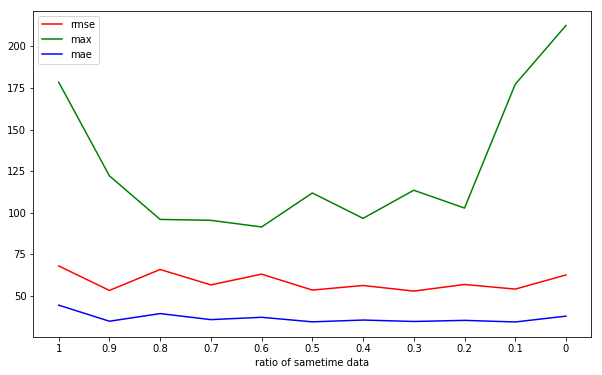

In [64]:
rmse,_max,mae=load_file('alter_in/'+str(102)+'/不同比例历史同期数据.pkl')
plt.figure(figsize=(10,6))
x=list(range(11))
x_names=['1','0.9','0.8','0.7','0.6','0.5','0.4','0.3','0.2','0.1','0']

plt.plot(x,rmse,label='rmse',color='r')
plt.plot(x,_max,label='max',color='g')
plt.plot(x,mae,label='mae',color='b')

plt.xticks(x,x_names)
plt.xlabel('ratio of sametime data')
plt.legend()
plt.show()

In [55]:
different_percent_sametime(102,in_seq)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Train on 1881 samples, validate on 99 samples
Epoch 1/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.2699 - val_loss: 0.1790
Epoch 2/500
1881/1881 [==============================] - 1s 656us/step - loss: 0.2249 - val_loss: 0.1760
Epoch 3/500
1881/1881 [==============================] - 1s 659us/step - loss: 0.2192 - val_loss: 0.1865
Epoch 4/500
1881/1881 [==============================] - 1s 653us/step - loss: 0.2078 - val_loss: 0.1579
Epoch 5/500
1881/1881 [==============================] - 1s 670us/step - loss: 0.2083 - val_loss: 0.1877
Epoch 6/500
1881/1881 [==============================] - 1s 664us/step - loss: 0.1997 - val_loss: 0.2135
Epoch 7/500
1881/1881 [==============================] - 1s 668us/step - loss: 0.1917 - val_loss: 0.1607
Epoch 8/500
1881/1881 [==============================] - 1s 683us/step - loss: 0.1894 - val_loss: 0.1950
Epoch 9/500
1881/1881 [==============================] - 1s 678us/step - loss: 0.1899 - val_loss: 0.1654
Epoch 10/50

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0609 - val_loss: 0.1099
Epoch 79/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0600 - val_loss: 0.0927
Epoch 80/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.0605 - val_loss: 0.1208
Epoch 81/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0608 - val_loss: 0.1051
Epoch 82/500
1881/1881 [==============================] - 1s 642us/step - loss: 0.0576 - val_loss: 0.1278
Epoch 83/500
1881/1881 [==============================] - 1s 639us/step - loss: 0.0568 - val_loss: 0.1181
Epoch 84/500
1881/1881 [==============================] - 1s 659us/step - loss: 0.0574 - val_loss: 0.1500
Epoch 85/500
1881/1881 [==============================] - 1s 655us/step - loss: 0.0574 - val_loss: 0.1565
Epoch 86/500
1881/1881 [==============================] - 1s 653us/step - loss: 0.0562 - val_loss: 0.1410
Epoch 87/500
1881/1881 [==============================] - 1s 663us/

Epoch 232/500
1881/1881 [==============================] - 3s 1ms/step - loss: 0.0266 - val_loss: 0.1307
Epoch 233/500
1881/1881 [==============================] - 5s 2ms/step - loss: 0.0261 - val_loss: 0.1317
Epoch 234/500
1881/1881 [==============================] - 3s 1ms/step - loss: 0.0266 - val_loss: 0.1388
Epoch 235/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0272 - val_loss: 0.1722
Epoch 236/500
1881/1881 [==============================] - 1s 661us/step - loss: 0.0273 - val_loss: 0.1303
Epoch 237/500
1881/1881 [==============================] - 1s 629us/step - loss: 0.0261 - val_loss: 0.1302
Epoch 238/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0261 - val_loss: 0.1422
Epoch 239/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0262 - val_loss: 0.1447
Epoch 240/500
1881/1881 [==============================] - 1s 652us/step - loss: 0.0250 - val_loss: 0.1350
Epoch 241/500
1881/1881 [==================

Epoch 309/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0196 - val_loss: 0.1595
Epoch 310/500
1881/1881 [==============================] - 1s 785us/step - loss: 0.0200 - val_loss: 0.1397
Epoch 311/500
1881/1881 [==============================] - 1s 787us/step - loss: 0.0197 - val_loss: 0.1317
Epoch 312/500
1881/1881 [==============================] - 1s 763us/step - loss: 0.0193 - val_loss: 0.1521
Epoch 313/500
1881/1881 [==============================] - 1s 721us/step - loss: 0.0194 - val_loss: 0.1577
Epoch 314/500
1881/1881 [==============================] - 1s 645us/step - loss: 0.0195 - val_loss: 0.1342
Epoch 315/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0197 - val_loss: 0.1468
Epoch 316/500
1881/1881 [==============================] - 1s 649us/step - loss: 0.0199 - val_loss: 0.1803
Epoch 317/500
1881/1881 [==============================] - 1s 667us/step - loss: 0.0187 - val_loss: 0.1655
Epoch 318/500
1881/1881 [==============

Epoch 386/500
1881/1881 [==============================] - 2s 916us/step - loss: 0.0155 - val_loss: 0.1775
Epoch 387/500
1881/1881 [==============================] - 1s 641us/step - loss: 0.0155 - val_loss: 0.1597
Epoch 388/500
1881/1881 [==============================] - 1s 640us/step - loss: 0.0155 - val_loss: 0.1511
Epoch 389/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0151 - val_loss: 0.1581
Epoch 390/500
1881/1881 [==============================] - 1s 638us/step - loss: 0.0166 - val_loss: 0.1374
Epoch 391/500
1881/1881 [==============================] - 1s 636us/step - loss: 0.0159 - val_loss: 0.1762
Epoch 392/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.0160 - val_loss: 0.1488
Epoch 393/500
1881/1881 [==============================] - 1s 646us/step - loss: 0.0155 - val_loss: 0.1508
Epoch 394/500
1881/1881 [==============================] - 1s 645us/step - loss: 0.0150 - val_loss: 0.1506
Epoch 395/500
1881/1881 [============

Epoch 463/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.0126 - val_loss: 0.1766
Epoch 464/500
1881/1881 [==============================] - 2s 818us/step - loss: 0.0120 - val_loss: 0.1704
Epoch 465/500
1881/1881 [==============================] - 2s 993us/step - loss: 0.0123 - val_loss: 0.1697
Epoch 466/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0131 - val_loss: 0.1827
Epoch 467/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.0126 - val_loss: 0.1686
Epoch 468/500
1881/1881 [==============================] - 3s 1ms/step - loss: 0.0129 - val_loss: 0.1406
Epoch 469/500
1881/1881 [==============================] - 1s 638us/step - loss: 0.0136 - val_loss: 0.1479
Epoch 470/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.0126 - val_loss: 0.1748
Epoch 471/500
1881/1881 [==============================] - 1s 656us/step - loss: 0.0130 - val_loss: 0.1526
Epoch 472/500
1881/1881 [==================

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1881 samples, validate on 99 samples
Epoch 1/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.2860 - val_loss: 0.1792
Epoch 2/500
1881/1881 [==============================] - 1s 645us/step - loss: 0.2125 - val_loss: 0.1925
Epoch 3/500
1881/1881 [==============================] - 1s 643us/step - loss: 0.2029 - val_loss: 0.2097
Epoch 4/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.1971 - val_loss: 0.1707
Epoch 5/500
1881/1881 [==============================] - 1s 688us/step - loss: 0.1890 - val_loss: 0.1938
Epoch 6/500
1881/1881 [==============================] - 2s 818us/step - loss: 0.1772 - val_loss: 0.1572
Epoch 7/500
1881/1881 [==============================] - 1s 761us/step - loss: 0.1774 - val_loss: 0.1407
Epoch 8/500
1881/1881 [==============================] - 1s 757us/step - loss: 0.1627 - val_loss: 0.2122
Epoch 9/500
1881/1881 [==============================] - 2s 838us/step - loss: 0.1574 - val_loss: 0.1524
Epoch 10/50

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0360 - val_loss: 0.0698
Epoch 156/500
1881/1881 [==============================] - 3s 1ms/step - loss: 0.0353 - val_loss: 0.0803
Epoch 157/500
1881/1881 [==============================] - 3s 1ms/step - loss: 0.0356 - val_loss: 0.0650
Epoch 158/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.0371 - val_loss: 0.0934
Epoch 159/500
1881/1881 [==============================] - 1s 645us/step - loss: 0.0373 - val_loss: 0.0711
Epoch 160/500
1881/1881 [==============================] - 1s 640us/step - loss: 0.0352 - val_loss: 0.0709
Epoch 161/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0354 - val_loss: 0.0683
Epoch 162/500
1881/1881 [==============================] - 1s 640us/step - loss: 0.0360 - val_loss: 0.0553
Epoch 163/500
1881/1881 [==============================] - 1s 643us/step - loss: 0.0371 - val_loss: 0.0675
Epoch 164/500
1881/1881 [==============================] 

Epoch 232/500
1881/1881 [==============================] - 1s 649us/step - loss: 0.0291 - val_loss: 0.0712
Epoch 233/500
1881/1881 [==============================] - 1s 667us/step - loss: 0.0269 - val_loss: 0.0647
Epoch 234/500
1881/1881 [==============================] - 2s 900us/step - loss: 0.0287 - val_loss: 0.0597
Epoch 235/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0271 - val_loss: 0.0669
Epoch 236/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.0262 - val_loss: 0.0764
Epoch 237/500
1881/1881 [==============================] - 4s 2ms/step - loss: 0.0261 - val_loss: 0.0818
Epoch 238/500
1881/1881 [==============================] - 1s 723us/step - loss: 0.0281 - val_loss: 0.0628
Epoch 239/500
1881/1881 [==============================] - 1s 737us/step - loss: 0.0258 - val_loss: 0.0734
Epoch 240/500
1881/1881 [==============================] - 1s 740us/step - loss: 0.0263 - val_loss: 0.0759
Epoch 241/500
1881/1881 [==================

Epoch 309/500
1881/1881 [==============================] - 1s 653us/step - loss: 0.0204 - val_loss: 0.0783
Epoch 310/500
1881/1881 [==============================] - 1s 645us/step - loss: 0.0200 - val_loss: 0.0606
Epoch 311/500
1881/1881 [==============================] - 1s 675us/step - loss: 0.0204 - val_loss: 0.0652
Epoch 312/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.0203 - val_loss: 0.0670
Epoch 313/500
1881/1881 [==============================] - 1s 650us/step - loss: 0.0204 - val_loss: 0.0612
Epoch 314/500
1881/1881 [==============================] - 1s 670us/step - loss: 0.0212 - val_loss: 0.0512
Epoch 315/500
1881/1881 [==============================] - 2s 937us/step - loss: 0.0203 - val_loss: 0.0590
Epoch 316/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0198 - val_loss: 0.0671
Epoch 317/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0194 - val_loss: 0.0720
Epoch 318/500
1881/1881 [================

Epoch 386/500
1881/1881 [==============================] - 1s 645us/step - loss: 0.0153 - val_loss: 0.0683
Epoch 387/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0167 - val_loss: 0.0658
Epoch 388/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0159 - val_loss: 0.0540
Epoch 389/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0146 - val_loss: 0.0580
Epoch 390/500
1881/1881 [==============================] - 1s 643us/step - loss: 0.0154 - val_loss: 0.0843
Epoch 391/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0155 - val_loss: 0.0876
Epoch 392/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0158 - val_loss: 0.0740
Epoch 393/500
1881/1881 [==============================] - 1s 636us/step - loss: 0.0149 - val_loss: 0.0669
Epoch 394/500
1881/1881 [==============================] - 1s 645us/step - loss: 0.0159 - val_loss: 0.0557
Epoch 395/500
1881/1881 [============

1881/1881 [==============================] - 1s 631us/step - loss: 0.0747 - val_loss: 0.0750
Epoch 39/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.0720 - val_loss: 0.0783
Epoch 40/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0716 - val_loss: 0.1093
Epoch 41/500
1881/1881 [==============================] - 1s 749us/step - loss: 0.0747 - val_loss: 0.1408
Epoch 42/500
1881/1881 [==============================] - 2s 888us/step - loss: 0.0734 - val_loss: 0.0586
Epoch 43/500
1881/1881 [==============================] - 2s 900us/step - loss: 0.0724 - val_loss: 0.0648
Epoch 44/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0672 - val_loss: 0.0743
Epoch 45/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0710 - val_loss: 0.1151
Epoch 46/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0698 - val_loss: 0.0776
Epoch 47/500
1881/1881 [==============================] - 1s 649u

1881/1881 [==============================] - 1s 645us/step - loss: 0.0295 - val_loss: 0.1761
Epoch 192/500
1881/1881 [==============================] - 1s 650us/step - loss: 0.0287 - val_loss: 0.1633
Epoch 193/500
1881/1881 [==============================] - 1s 646us/step - loss: 0.0288 - val_loss: 0.1417
Epoch 194/500
1881/1881 [==============================] - 1s 653us/step - loss: 0.0292 - val_loss: 0.1519
Epoch 195/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0301 - val_loss: 0.1185
Epoch 196/500
1881/1881 [==============================] - 2s 927us/step - loss: 0.0289 - val_loss: 0.1699
Epoch 197/500
1881/1881 [==============================] - 2s 827us/step - loss: 0.0288 - val_loss: 0.1414
Epoch 198/500
1881/1881 [==============================] - 2s 828us/step - loss: 0.0298 - val_loss: 0.1480
Epoch 199/500
1881/1881 [==============================] - 2s 964us/step - loss: 0.0288 - val_loss: 0.1469
Epoch 200/500
1881/1881 [==========================

Epoch 344/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.0167 - val_loss: 0.1850
Epoch 345/500
1881/1881 [==============================] - 1s 646us/step - loss: 0.0167 - val_loss: 0.1484
Epoch 346/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0178 - val_loss: 0.2091
Epoch 347/500
1881/1881 [==============================] - 1s 636us/step - loss: 0.0167 - val_loss: 0.1377
Epoch 348/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0163 - val_loss: 0.1860
Epoch 349/500
1881/1881 [==============================] - 2s 836us/step - loss: 0.0159 - val_loss: 0.2082
Epoch 350/500
1881/1881 [==============================] - 2s 824us/step - loss: 0.0163 - val_loss: 0.1742
Epoch 351/500
1881/1881 [==============================] - 2s 814us/step - loss: 0.0168 - val_loss: 0.1648
Epoch 352/500
1881/1881 [==============================] - 2s 913us/step - loss: 0.0182 - val_loss: 0.1980
Epoch 353/500
1881/1881 [============

Epoch 497/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.0110 - val_loss: 0.1236
Epoch 498/500
1881/1881 [==============================] - 1s 646us/step - loss: 0.0105 - val_loss: 0.1415
Epoch 499/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0110 - val_loss: 0.1261
Epoch 500/500
1881/1881 [==============================] - 1s 654us/step - loss: 0.0105 - val_loss: 0.1568
rmse: 65.88245095014314
max 95.97
mae 39.35795698924733
Train on 1881 samples, validate on 99 samples
Epoch 1/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.3193 - val_loss: 0.1740
Epoch 2/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.2051 - val_loss: 0.1592
Epoch 3/500
1881/1881 [==============================] - 1s 639us/step - loss: 0.1869 - val_loss: 0.1705
Epoch 4/500
1881/1881 [==============================] - 1s 635us/step - loss: 0.1800 - val_loss: 0.2097
Epoch 5/500
1881/1881 [=============================

Epoch 150/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0340 - val_loss: 0.0906
Epoch 151/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0335 - val_loss: 0.1125
Epoch 152/500
1881/1881 [==============================] - 1s 687us/step - loss: 0.0341 - val_loss: 0.0746
Epoch 153/500
1881/1881 [==============================] - 1s 643us/step - loss: 0.0341 - val_loss: 0.1030
Epoch 154/500
1881/1881 [==============================] - 1s 649us/step - loss: 0.0324 - val_loss: 0.1064
Epoch 155/500
1881/1881 [==============================] - 1s 642us/step - loss: 0.0328 - val_loss: 0.0824
Epoch 156/500
1881/1881 [==============================] - 1s 641us/step - loss: 0.0317 - val_loss: 0.0914
Epoch 157/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.0343 - val_loss: 0.1014
Epoch 158/500
1881/1881 [==============================] - 1s 651us/step - loss: 0.0322 - val_loss: 0.0955
Epoch 159/500
1881/1881 [================

Epoch 227/500
1881/1881 [==============================] - 1s 643us/step - loss: 0.0237 - val_loss: 0.0890
Epoch 228/500
1881/1881 [==============================] - 1s 656us/step - loss: 0.0252 - val_loss: 0.0841
Epoch 229/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0230 - val_loss: 0.0830
Epoch 230/500
1881/1881 [==============================] - 1s 679us/step - loss: 0.0246 - val_loss: 0.0957
Epoch 231/500
1881/1881 [==============================] - 2s 821us/step - loss: 0.0233 - val_loss: 0.1090
Epoch 232/500
1881/1881 [==============================] - 2s 839us/step - loss: 0.0231 - val_loss: 0.0880
Epoch 233/500
1881/1881 [==============================] - 2s 828us/step - loss: 0.0235 - val_loss: 0.0971
Epoch 234/500
1881/1881 [==============================] - 2s 944us/step - loss: 0.0227 - val_loss: 0.0887
Epoch 235/500
1881/1881 [==============================] - 2s 979us/step - loss: 0.0246 - val_loss: 0.0890
Epoch 236/500
1881/1881 [============

Epoch 380/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.0131 - val_loss: 0.0992
Epoch 381/500
1881/1881 [==============================] - 1s 646us/step - loss: 0.0141 - val_loss: 0.0854
Epoch 382/500
1881/1881 [==============================] - 1s 643us/step - loss: 0.0144 - val_loss: 0.0971
Epoch 383/500
1881/1881 [==============================] - 1s 635us/step - loss: 0.0140 - val_loss: 0.0892
Epoch 384/500
1881/1881 [==============================] - 2s 853us/step - loss: 0.0147 - val_loss: 0.0816
Epoch 385/500
1881/1881 [==============================] - 2s 831us/step - loss: 0.0142 - val_loss: 0.0986
Epoch 386/500
1881/1881 [==============================] - 2s 819us/step - loss: 0.0128 - val_loss: 0.1056
Epoch 387/500
1881/1881 [==============================] - 2s 959us/step - loss: 0.0149 - val_loss: 0.0946
Epoch 388/500
1881/1881 [==============================] - 2s 930us/step - loss: 0.0128 - val_loss: 0.1208
Epoch 389/500
1881/1881 [============

1881/1881 [==============================] - 1s 661us/step - loss: 0.0813 - val_loss: 0.0853
Epoch 33/500
1881/1881 [==============================] - 2s 883us/step - loss: 0.0765 - val_loss: 0.0848
Epoch 34/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0764 - val_loss: 0.0861
Epoch 35/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0749 - val_loss: 0.1001
Epoch 36/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.0737 - val_loss: 0.0778
Epoch 37/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0720 - val_loss: 0.1330
Epoch 38/500
1881/1881 [==============================] - 1s 641us/step - loss: 0.0690 - val_loss: 0.0842
Epoch 39/500
1881/1881 [==============================] - 1s 642us/step - loss: 0.0719 - val_loss: 0.0776
Epoch 40/500
1881/1881 [==============================] - 1s 656us/step - loss: 0.0683 - val_loss: 0.0735
Epoch 41/500
1881/1881 [==============================] - 1s 647us/

Epoch 186/500
1881/1881 [==============================] - 1s 640us/step - loss: 0.0303 - val_loss: 0.1274
Epoch 187/500
1881/1881 [==============================] - 1s 666us/step - loss: 0.0294 - val_loss: 0.1387
Epoch 188/500
1881/1881 [==============================] - 1s 642us/step - loss: 0.0292 - val_loss: 0.1137
Epoch 189/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.0279 - val_loss: 0.1475
Epoch 190/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.0272 - val_loss: 0.1660
Epoch 191/500
1881/1881 [==============================] - 1s 643us/step - loss: 0.0280 - val_loss: 0.1485
Epoch 192/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0273 - val_loss: 0.1510
Epoch 193/500
1881/1881 [==============================] - 1s 632us/step - loss: 0.0287 - val_loss: 0.1382
Epoch 194/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0281 - val_loss: 0.1604
Epoch 195/500
1881/1881 [============

Epoch 339/500
1881/1881 [==============================] - 1s 638us/step - loss: 0.0156 - val_loss: 0.1673
Epoch 340/500
1881/1881 [==============================] - 1s 639us/step - loss: 0.0160 - val_loss: 0.2006
Epoch 341/500
1881/1881 [==============================] - 1s 643us/step - loss: 0.0167 - val_loss: 0.1806
Epoch 342/500
1881/1881 [==============================] - 1s 655us/step - loss: 0.0152 - val_loss: 0.1857
Epoch 343/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0159 - val_loss: 0.1744
Epoch 344/500
1881/1881 [==============================] - 1s 646us/step - loss: 0.0150 - val_loss: 0.1971
Epoch 345/500
1881/1881 [==============================] - 1s 641us/step - loss: 0.0150 - val_loss: 0.1881
Epoch 346/500
1881/1881 [==============================] - 1s 655us/step - loss: 0.0148 - val_loss: 0.1872
Epoch 347/500
1881/1881 [==============================] - 1s 665us/step - loss: 0.0145 - val_loss: 0.1541
Epoch 348/500
1881/1881 [============

Epoch 492/500
1881/1881 [==============================] - 1s 658us/step - loss: 0.0099 - val_loss: 0.1892
Epoch 493/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0101 - val_loss: 0.1936
Epoch 494/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0102 - val_loss: 0.2002
Epoch 495/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0096 - val_loss: 0.1890
Epoch 496/500
1881/1881 [==============================] - 1s 659us/step - loss: 0.0102 - val_loss: 0.2010
Epoch 497/500
1881/1881 [==============================] - 1s 638us/step - loss: 0.0098 - val_loss: 0.2168
Epoch 498/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0105 - val_loss: 0.2031
Epoch 499/500
1881/1881 [==============================] - 1s 694us/step - loss: 0.0101 - val_loss: 0.2206
Epoch 500/500
1881/1881 [==============================] - 2s 837us/step - loss: 0.0089 - val_loss: 0.2158
rmse: 63.07704991029543
max 91.43
mae

1881/1881 [==============================] - 2s 981us/step - loss: 0.0312 - val_loss: 0.0995
Epoch 146/500
1881/1881 [==============================] - 2s 998us/step - loss: 0.0337 - val_loss: 0.1197
Epoch 147/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0314 - val_loss: 0.1094
Epoch 148/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.0301 - val_loss: 0.1176
Epoch 149/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0312 - val_loss: 0.1233
Epoch 150/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0306 - val_loss: 0.1127
Epoch 151/500
1881/1881 [==============================] - 1s 656us/step - loss: 0.0313 - val_loss: 0.0832
Epoch 152/500
1881/1881 [==============================] - 1s 646us/step - loss: 0.0315 - val_loss: 0.1159
Epoch 153/500
1881/1881 [==============================] - 1s 657us/step - loss: 0.0300 - val_loss: 0.0907
Epoch 154/500
1881/1881 [==============================] 

Epoch 222/500
1881/1881 [==============================] - 1s 667us/step - loss: 0.0238 - val_loss: 0.0980
Epoch 223/500
1881/1881 [==============================] - 1s 663us/step - loss: 0.0231 - val_loss: 0.0824
Epoch 224/500
1881/1881 [==============================] - 1s 666us/step - loss: 0.0232 - val_loss: 0.1123
Epoch 225/500
1881/1881 [==============================] - 1s 643us/step - loss: 0.0226 - val_loss: 0.0931
Epoch 226/500
1881/1881 [==============================] - 1s 659us/step - loss: 0.0225 - val_loss: 0.0854
Epoch 227/500
1881/1881 [==============================] - 1s 655us/step - loss: 0.0238 - val_loss: 0.0881
Epoch 228/500
1881/1881 [==============================] - 1s 662us/step - loss: 0.0224 - val_loss: 0.0851
Epoch 229/500
1881/1881 [==============================] - 1s 695us/step - loss: 0.0227 - val_loss: 0.1095
Epoch 230/500
1881/1881 [==============================] - 2s 898us/step - loss: 0.0226 - val_loss: 0.0985
Epoch 231/500
1881/1881 [============

Epoch 375/500
1881/1881 [==============================] - 2s 907us/step - loss: 0.0133 - val_loss: 0.0949
Epoch 376/500
1881/1881 [==============================] - 2s 910us/step - loss: 0.0134 - val_loss: 0.0732
Epoch 377/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0132 - val_loss: 0.0798
Epoch 378/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0128 - val_loss: 0.0661
Epoch 379/500
1881/1881 [==============================] - 1s 723us/step - loss: 0.0139 - val_loss: 0.0627
Epoch 380/500
1881/1881 [==============================] - 1s 652us/step - loss: 0.0131 - val_loss: 0.0970
Epoch 381/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.0136 - val_loss: 0.0820
Epoch 382/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0132 - val_loss: 0.0820
Epoch 383/500
1881/1881 [==============================] - 1s 663us/step - loss: 0.0129 - val_loss: 0.0734
Epoch 384/500
1881/1881 [================

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0815 - val_loss: 0.0746
Epoch 28/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0816 - val_loss: 0.0949
Epoch 29/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.0807 - val_loss: 0.0903
Epoch 30/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0802 - val_loss: 0.0867
Epoch 31/500
1881/1881 [==============================] - 1s 655us/step - loss: 0.0804 - val_loss: 0.0764
Epoch 32/500
1881/1881 [==============================] - 1s 641us/step - loss: 0.0760 - val_loss: 0.0685
Epoch 33/500
1881/1881 [==============================] - 1s 652us/step - loss: 0.0759 - val_loss: 0.0783
Epoch 34/500
1881/1881 [==============================] - 1s 650us/step - loss: 0.0757 - val_loss: 0.1059
Epoch 35/500
1881/1881 [==============================] - 1s 641us/step - loss: 0.0770 - val_loss: 0.0741
Epoch 36/500
1881/1881 [==============================] - 1s 648us/

Epoch 181/500
1881/1881 [==============================] - 2s 830us/step - loss: 0.0287 - val_loss: 0.0981
Epoch 182/500
1881/1881 [==============================] - 1s 646us/step - loss: 0.0279 - val_loss: 0.1088
Epoch 183/500
1881/1881 [==============================] - 1s 658us/step - loss: 0.0287 - val_loss: 0.1226
Epoch 184/500
1881/1881 [==============================] - 1s 660us/step - loss: 0.0287 - val_loss: 0.0893
Epoch 185/500
1881/1881 [==============================] - 1s 650us/step - loss: 0.0280 - val_loss: 0.0895
Epoch 186/500
1881/1881 [==============================] - 1s 656us/step - loss: 0.0272 - val_loss: 0.1342
Epoch 187/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0278 - val_loss: 0.1300
Epoch 188/500
1881/1881 [==============================] - 1s 652us/step - loss: 0.0273 - val_loss: 0.1312
Epoch 189/500
1881/1881 [==============================] - 1s 645us/step - loss: 0.0275 - val_loss: 0.1016
Epoch 190/500
1881/1881 [============

Epoch 334/500
1881/1881 [==============================] - 1s 673us/step - loss: 0.0176 - val_loss: 0.1140
Epoch 335/500
1881/1881 [==============================] - 1s 660us/step - loss: 0.0175 - val_loss: 0.1022
Epoch 336/500
1881/1881 [==============================] - 1s 658us/step - loss: 0.0170 - val_loss: 0.1124
Epoch 337/500
1881/1881 [==============================] - 1s 669us/step - loss: 0.0169 - val_loss: 0.1095
Epoch 338/500
1881/1881 [==============================] - 1s 655us/step - loss: 0.0179 - val_loss: 0.1030
Epoch 339/500
1881/1881 [==============================] - 1s 666us/step - loss: 0.0179 - val_loss: 0.0993
Epoch 340/500
1881/1881 [==============================] - 1s 666us/step - loss: 0.0174 - val_loss: 0.1254
Epoch 341/500
1881/1881 [==============================] - 1s 676us/step - loss: 0.0172 - val_loss: 0.1054
Epoch 342/500
1881/1881 [==============================] - 1s 664us/step - loss: 0.0172 - val_loss: 0.1191
Epoch 343/500
1881/1881 [============

Epoch 487/500
1881/1881 [==============================] - 1s 641us/step - loss: 0.0103 - val_loss: 0.1014
Epoch 488/500
1881/1881 [==============================] - 1s 649us/step - loss: 0.0103 - val_loss: 0.0921
Epoch 489/500
1881/1881 [==============================] - 1s 666us/step - loss: 0.0116 - val_loss: 0.0993
Epoch 490/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0109 - val_loss: 0.0860
Epoch 491/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0103 - val_loss: 0.0991
Epoch 492/500
1881/1881 [==============================] - 1s 653us/step - loss: 0.0112 - val_loss: 0.0946
Epoch 493/500
1881/1881 [==============================] - 1s 788us/step - loss: 0.0107 - val_loss: 0.1020
Epoch 494/500
1881/1881 [==============================] - 2s 831us/step - loss: 0.0104 - val_loss: 0.0880
Epoch 495/500
1881/1881 [==============================] - 2s 842us/step - loss: 0.0106 - val_loss: 0.0894
Epoch 496/500
1881/1881 [============

1881/1881 [==============================] - 1s 646us/step - loss: 0.0343 - val_loss: 0.0597
Epoch 141/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.0342 - val_loss: 0.0535
Epoch 142/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0367 - val_loss: 0.0574
Epoch 143/500
1881/1881 [==============================] - 2s 890us/step - loss: 0.0338 - val_loss: 0.0650
Epoch 144/500
1881/1881 [==============================] - 2s 917us/step - loss: 0.0338 - val_loss: 0.0634
Epoch 145/500
1881/1881 [==============================] - 2s 899us/step - loss: 0.0338 - val_loss: 0.0737
Epoch 146/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0363 - val_loss: 0.0555
Epoch 147/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0346 - val_loss: 0.0578
Epoch 148/500
1881/1881 [==============================] - 1s 755us/step - loss: 0.0338 - val_loss: 0.0665
Epoch 149/500
1881/1881 [==============================

Epoch 217/500
1881/1881 [==============================] - 1s 643us/step - loss: 0.0286 - val_loss: 0.0658
Epoch 218/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0255 - val_loss: 0.0643
Epoch 219/500
1881/1881 [==============================] - 1s 674us/step - loss: 0.0276 - val_loss: 0.0761
Epoch 220/500
1881/1881 [==============================] - 1s 654us/step - loss: 0.0259 - val_loss: 0.0572
Epoch 221/500
1881/1881 [==============================] - 1s 651us/step - loss: 0.0252 - val_loss: 0.0706
Epoch 222/500
1881/1881 [==============================] - 1s 652us/step - loss: 0.0268 - val_loss: 0.0583
Epoch 223/500
1881/1881 [==============================] - 1s 664us/step - loss: 0.0265 - val_loss: 0.0697
Epoch 224/500
1881/1881 [==============================] - 1s 642us/step - loss: 0.0268 - val_loss: 0.0671
Epoch 225/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0247 - val_loss: 0.0756
Epoch 226/500
1881/1881 [============

Epoch 370/500
1881/1881 [==============================] - 1s 653us/step - loss: 0.0164 - val_loss: 0.0943
Epoch 371/500
1881/1881 [==============================] - 1s 653us/step - loss: 0.0163 - val_loss: 0.1145
Epoch 372/500
1881/1881 [==============================] - 1s 653us/step - loss: 0.0158 - val_loss: 0.0926
Epoch 373/500
1881/1881 [==============================] - 1s 642us/step - loss: 0.0158 - val_loss: 0.0935
Epoch 374/500
1881/1881 [==============================] - 1s 640us/step - loss: 0.0165 - val_loss: 0.0993
Epoch 375/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0172 - val_loss: 0.0806
Epoch 376/500
1881/1881 [==============================] - 1s 669us/step - loss: 0.0155 - val_loss: 0.1134
Epoch 377/500
1881/1881 [==============================] - 1s 649us/step - loss: 0.0161 - val_loss: 0.1042
Epoch 378/500
1881/1881 [==============================] - 1s 720us/step - loss: 0.0160 - val_loss: 0.1012
Epoch 379/500
1881/1881 [============

1881/1881 [==============================] - 1s 725us/step - loss: 0.0965 - val_loss: 0.1059
Epoch 23/500
1881/1881 [==============================] - 2s 920us/step - loss: 0.0947 - val_loss: 0.1021
Epoch 24/500
1881/1881 [==============================] - 2s 911us/step - loss: 0.0896 - val_loss: 0.0987
Epoch 25/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0887 - val_loss: 0.1399
Epoch 26/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0900 - val_loss: 0.0791
Epoch 27/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0856 - val_loss: 0.1057
Epoch 28/500
1881/1881 [==============================] - 1s 658us/step - loss: 0.0849 - val_loss: 0.1077
Epoch 29/500
1881/1881 [==============================] - 1s 655us/step - loss: 0.0839 - val_loss: 0.0999
Epoch 30/500
1881/1881 [==============================] - 1s 652us/step - loss: 0.0848 - val_loss: 0.1044
Epoch 31/500
1881/1881 [==============================] - 1s 652u

1881/1881 [==============================] - 2s 811us/step - loss: 0.0302 - val_loss: 0.1021
Epoch 176/500
1881/1881 [==============================] - 2s 900us/step - loss: 0.0307 - val_loss: 0.0961
Epoch 177/500
1881/1881 [==============================] - 2s 932us/step - loss: 0.0313 - val_loss: 0.1150
Epoch 178/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0313 - val_loss: 0.0887
Epoch 179/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0315 - val_loss: 0.1450
Epoch 180/500
1881/1881 [==============================] - 2s 971us/step - loss: 0.0303 - val_loss: 0.1196
Epoch 181/500
1881/1881 [==============================] - 1s 662us/step - loss: 0.0307 - val_loss: 0.0773
Epoch 182/500
1881/1881 [==============================] - 1s 656us/step - loss: 0.0299 - val_loss: 0.1137
Epoch 183/500
1881/1881 [==============================] - 1s 664us/step - loss: 0.0293 - val_loss: 0.1158
Epoch 184/500
1881/1881 [==============================

Epoch 252/500
1881/1881 [==============================] - 1s 640us/step - loss: 0.0232 - val_loss: 0.0646
Epoch 253/500
1881/1881 [==============================] - 1s 649us/step - loss: 0.0230 - val_loss: 0.0926
Epoch 254/500
1881/1881 [==============================] - 1s 660us/step - loss: 0.0243 - val_loss: 0.1054
Epoch 255/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0237 - val_loss: 0.1003
Epoch 256/500
1881/1881 [==============================] - 1s 650us/step - loss: 0.0227 - val_loss: 0.1134
Epoch 257/500
1881/1881 [==============================] - 1s 643us/step - loss: 0.0220 - val_loss: 0.0966
Epoch 258/500
1881/1881 [==============================] - 1s 655us/step - loss: 0.0232 - val_loss: 0.0774
Epoch 259/500
1881/1881 [==============================] - 1s 764us/step - loss: 0.0236 - val_loss: 0.0840
Epoch 260/500
1881/1881 [==============================] - 2s 817us/step - loss: 0.0235 - val_loss: 0.0839
Epoch 261/500
1881/1881 [============

Epoch 405/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.0142 - val_loss: 0.0800
Epoch 406/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0144 - val_loss: 0.0851
Epoch 407/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0132 - val_loss: 0.0699
Epoch 408/500
1881/1881 [==============================] - 1s 663us/step - loss: 0.0137 - val_loss: 0.0845
Epoch 409/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0141 - val_loss: 0.0830
Epoch 410/500
1881/1881 [==============================] - 1s 651us/step - loss: 0.0151 - val_loss: 0.0803
Epoch 411/500
1881/1881 [==============================] - 1s 696us/step - loss: 0.0127 - val_loss: 0.0971
Epoch 412/500
1881/1881 [==============================] - 1s 778us/step - loss: 0.0140 - val_loss: 0.0714
Epoch 413/500
1881/1881 [==============================] - 1s 765us/step - loss: 0.0139 - val_loss: 0.0827
Epoch 414/500
1881/1881 [============

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0630 - val_loss: 0.0667
Epoch 58/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0699 - val_loss: 0.0753
Epoch 59/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0657 - val_loss: 0.0762
Epoch 60/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.0671 - val_loss: 0.0595
Epoch 61/500
1881/1881 [==============================] - 2s 970us/step - loss: 0.0633 - val_loss: 0.0698
Epoch 62/500
1881/1881 [==============================] - 1s 646us/step - loss: 0.0626 - val_loss: 0.0725
Epoch 63/500
1881/1881 [==============================] - 1s 652us/step - loss: 0.0614 - val_loss: 0.0579
Epoch 64/500
1881/1881 [==============================] - 1s 645us/step - loss: 0.0629 - val_loss: 0.0695
Epoch 65/500
1881/1881 [==============================] - 1s 668us/step - loss: 0.0561 - val_loss: 0.0737
Epoch 66/500
1881/1881 [==============================] - 1s 656us/

Epoch 211/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0278 - val_loss: 0.0695
Epoch 212/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0292 - val_loss: 0.0859
Epoch 213/500
1881/1881 [==============================] - 2s 865us/step - loss: 0.0288 - val_loss: 0.0614
Epoch 214/500
1881/1881 [==============================] - 1s 653us/step - loss: 0.0292 - val_loss: 0.0663
Epoch 215/500
1881/1881 [==============================] - 1s 654us/step - loss: 0.0290 - val_loss: 0.0727
Epoch 216/500
1881/1881 [==============================] - 1s 651us/step - loss: 0.0283 - val_loss: 0.0568
Epoch 217/500
1881/1881 [==============================] - 1s 653us/step - loss: 0.0286 - val_loss: 0.0567
Epoch 218/500
1881/1881 [==============================] - 1s 654us/step - loss: 0.0280 - val_loss: 0.0592
Epoch 219/500
1881/1881 [==============================] - 1s 661us/step - loss: 0.0281 - val_loss: 0.0600
Epoch 220/500
1881/1881 [================

Epoch 364/500
1881/1881 [==============================] - 2s 836us/step - loss: 0.0196 - val_loss: 0.0798
Epoch 365/500
1881/1881 [==============================] - 2s 851us/step - loss: 0.0183 - val_loss: 0.0817
Epoch 366/500
1881/1881 [==============================] - 2s 836us/step - loss: 0.0192 - val_loss: 0.0808
Epoch 367/500
1881/1881 [==============================] - 2s 924us/step - loss: 0.0190 - val_loss: 0.0724
Epoch 368/500
1881/1881 [==============================] - 2s 902us/step - loss: 0.0187 - val_loss: 0.0812
Epoch 369/500
1881/1881 [==============================] - 2s 958us/step - loss: 0.0178 - val_loss: 0.0962
Epoch 370/500
1881/1881 [==============================] - 1s 700us/step - loss: 0.0195 - val_loss: 0.0766
Epoch 371/500
1881/1881 [==============================] - 1s 684us/step - loss: 0.0194 - val_loss: 0.0892
Epoch 372/500
1881/1881 [==============================] - 1s 684us/step - loss: 0.0198 - val_loss: 0.0918
Epoch 373/500
1881/1881 [============

Epoch 441/500
1881/1881 [==============================] - 1s 673us/step - loss: 0.0160 - val_loss: 0.0866
Epoch 442/500
1881/1881 [==============================] - 1s 665us/step - loss: 0.0149 - val_loss: 0.0796
Epoch 443/500
1881/1881 [==============================] - 1s 671us/step - loss: 0.0165 - val_loss: 0.0782
Epoch 444/500
1881/1881 [==============================] - 1s 666us/step - loss: 0.0155 - val_loss: 0.0761
Epoch 445/500
1881/1881 [==============================] - 1s 670us/step - loss: 0.0158 - val_loss: 0.0874
Epoch 446/500
1881/1881 [==============================] - 1s 680us/step - loss: 0.0174 - val_loss: 0.0723
Epoch 447/500
1881/1881 [==============================] - 1s 667us/step - loss: 0.0154 - val_loss: 0.0871
Epoch 448/500
1881/1881 [==============================] - 1s 665us/step - loss: 0.0143 - val_loss: 0.0750
Epoch 449/500
1881/1881 [==============================] - 1s 683us/step - loss: 0.0151 - val_loss: 0.0767
Epoch 450/500
1881/1881 [============

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1881 samples, validate on 99 samples
Epoch 1/500
1881/1881 [==============================] - 4s 2ms/step - loss: 0.3640 - val_loss: 0.2778
Epoch 2/500
1881/1881 [==============================] - 1s 669us/step - loss: 0.2562 - val_loss: 0.2343
Epoch 3/500
1881/1881 [==============================] - 1s 671us/step - loss: 0.2231 - val_loss: 0.1849
Epoch 4/500
1881/1881 [==============================] - 1s 689us/step - loss: 0.2000 - val_loss: 0.1834
Epoch 5/500
1881/1881 [==============================] - 2s 874us/step - loss: 0.1890 - val_loss: 0.2154
Epoch 6/500
1881/1881 [==============================] - 2s 842us/step - loss: 0.1852 - val_loss: 0.1722
Epoch 7/500
1881/1881 [==============================] - 2s 842us/step - loss: 0.1814 - val_loss: 0.1822
Epoch 8/500
1881/1881 [==============================] - 2s 864us/step - loss: 0.1662 - val_loss: 0.1700
Epoch 9/500
1881/1881 [==============================] - 2s 951us/step - loss: 0.1623 - val_loss: 0.1560
Epoch 10/50

1881/1881 [==============================] - 1s 679us/step - loss: 0.0379 - val_loss: 0.0528
Epoch 156/500
1881/1881 [==============================] - 1s 673us/step - loss: 0.0380 - val_loss: 0.0668
Epoch 157/500
1881/1881 [==============================] - 1s 671us/step - loss: 0.0365 - val_loss: 0.0503
Epoch 158/500
1881/1881 [==============================] - 1s 771us/step - loss: 0.0362 - val_loss: 0.0642
Epoch 159/500
1881/1881 [==============================] - 2s 855us/step - loss: 0.0369 - val_loss: 0.0608
Epoch 160/500
1881/1881 [==============================] - 2s 840us/step - loss: 0.0375 - val_loss: 0.0651
Epoch 161/500
1881/1881 [==============================] - 2s 914us/step - loss: 0.0371 - val_loss: 0.0517
Epoch 162/500
1881/1881 [==============================] - 2s 998us/step - loss: 0.0366 - val_loss: 0.0581
Epoch 163/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0363 - val_loss: 0.0734
Epoch 164/500
1881/1881 [============================

Epoch 232/500
1881/1881 [==============================] - 1s 669us/step - loss: 0.0278 - val_loss: 0.0858
Epoch 233/500
1881/1881 [==============================] - 1s 685us/step - loss: 0.0283 - val_loss: 0.0616
Epoch 234/500
1881/1881 [==============================] - 1s 666us/step - loss: 0.0272 - val_loss: 0.0679
Epoch 235/500
1881/1881 [==============================] - 1s 676us/step - loss: 0.0268 - val_loss: 0.0829
Epoch 236/500
1881/1881 [==============================] - 1s 688us/step - loss: 0.0286 - val_loss: 0.0740
Epoch 237/500
1881/1881 [==============================] - 2s 933us/step - loss: 0.0277 - val_loss: 0.0793
Epoch 238/500
1881/1881 [==============================] - 2s 939us/step - loss: 0.0264 - val_loss: 0.0848
Epoch 239/500
1881/1881 [==============================] - 2s 992us/step - loss: 0.0276 - val_loss: 0.0534
Epoch 240/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0258 - val_loss: 0.0719
Epoch 241/500
1881/1881 [==============

Epoch 309/500
1881/1881 [==============================] - 1s 668us/step - loss: 0.0216 - val_loss: 0.0750
Epoch 310/500
1881/1881 [==============================] - 1s 674us/step - loss: 0.0206 - val_loss: 0.0899
Epoch 311/500
1881/1881 [==============================] - 1s 676us/step - loss: 0.0213 - val_loss: 0.0719
Epoch 312/500
1881/1881 [==============================] - 1s 676us/step - loss: 0.0212 - val_loss: 0.0866
Epoch 313/500
1881/1881 [==============================] - 1s 663us/step - loss: 0.0208 - val_loss: 0.0604
Epoch 314/500
1881/1881 [==============================] - 1s 676us/step - loss: 0.0212 - val_loss: 0.0684
Epoch 315/500
1881/1881 [==============================] - 2s 833us/step - loss: 0.0218 - val_loss: 0.0771
Epoch 316/500
1881/1881 [==============================] - 2s 845us/step - loss: 0.0212 - val_loss: 0.0905
Epoch 317/500
1881/1881 [==============================] - 2s 859us/step - loss: 0.0215 - val_loss: 0.0795
Epoch 318/500
1881/1881 [============

Epoch 386/500
1881/1881 [==============================] - 1s 668us/step - loss: 0.0174 - val_loss: 0.0740
Epoch 387/500
1881/1881 [==============================] - 1s 685us/step - loss: 0.0179 - val_loss: 0.0818
Epoch 388/500
1881/1881 [==============================] - 1s 668us/step - loss: 0.0174 - val_loss: 0.0882
Epoch 389/500
1881/1881 [==============================] - 1s 666us/step - loss: 0.0186 - val_loss: 0.0873
Epoch 390/500
1881/1881 [==============================] - 1s 668us/step - loss: 0.0172 - val_loss: 0.0818
Epoch 391/500
1881/1881 [==============================] - 1s 691us/step - loss: 0.0180 - val_loss: 0.0767
Epoch 392/500
1881/1881 [==============================] - 2s 855us/step - loss: 0.0175 - val_loss: 0.0644
Epoch 393/500
1881/1881 [==============================] - 2s 849us/step - loss: 0.0174 - val_loss: 0.0623
Epoch 394/500
1881/1881 [==============================] - 2s 864us/step - loss: 0.0169 - val_loss: 0.0639
Epoch 395/500
1881/1881 [============

Epoch 463/500
1881/1881 [==============================] - 1s 662us/step - loss: 0.0144 - val_loss: 0.0627
Epoch 464/500
1881/1881 [==============================] - 1s 651us/step - loss: 0.0147 - val_loss: 0.0737
Epoch 465/500
1881/1881 [==============================] - 1s 653us/step - loss: 0.0137 - val_loss: 0.0747
Epoch 466/500
1881/1881 [==============================] - 1s 658us/step - loss: 0.0138 - val_loss: 0.0735
Epoch 467/500
1881/1881 [==============================] - 1s 642us/step - loss: 0.0136 - val_loss: 0.0713
Epoch 468/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.0144 - val_loss: 0.0813
Epoch 469/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0136 - val_loss: 0.0688
Epoch 470/500
1881/1881 [==============================] - 1s 671us/step - loss: 0.0148 - val_loss: 0.0802
Epoch 471/500
1881/1881 [==============================] - 1s 658us/step - loss: 0.0155 - val_loss: 0.0689
Epoch 472/500
1881/1881 [============

([68.02204870194052,
  53.27524996566157,
  65.88245095014314,
  56.600831544998236,
  63.07704991029543,
  53.50881957106341,
  56.248266570433245,
  52.87935304248599,
  56.86846655395708,
  54.0798794940836,
  62.58241808913667],
 [178.46,
  122.15,
  95.97,
  95.42,
  91.43,
  111.85,
  96.61,
  113.51,
  102.79,
  177.19,
  212.55],
 [44.43838709677418,
  34.764695340501795,
  39.35795698924733,
  35.731684587813604,
  37.134767025089594,
  34.401254480286745,
  35.4789247311828,
  34.622329749103926,
  35.285519713261664,
  34.321362007168474,
  37.82702508960573])

In [33]:
def predict_sametime(target_station,in_seq):
    in_seq_by_station=in_seq.loc[target_station].tolist()
    
    in_seq_by_station_norm=(in_seq_by_station-np.mean(in_seq_by_station))/np.std(in_seq_by_station)
    
    train_Y,test_Y=get_labels(in_seq_by_station_norm)
    
    train_single_X,test_single_X=get_block1(in_seq_by_station_norm)
    train_same_X,test_same_X=get_block2(in_seq_by_station_norm)
    
    #历史同期模型
    model = build_model_with_sametime()
    model.reset_states()
    model.fit(train_same_X,train_Y,batch_size=50,nb_epoch=500,validation_split=0.05)
    model.save('alter_in/'+str(target_station)+'/进站历史同期模型.h5')
    
    rmse1,max1,mae1=eva(test_same_X,test_Y,in_seq_by_station,model)
    
    #单LSTM
    model=build_single_model()
    model.reset_states()
    model.fit(train_single_X,train_Y,batch_size=50,nb_epoch=500,validation_split=0.05)
    model.save('alter_in/'+str(target_station)+'/单LSTM模型.h5')
    
    rmse2,max2,mae2=eva(test_single_X,test_Y,in_seq_by_station,model)
    
    save_file('alter_in/'+str(target_station)+'/历史同期VS单LSTM.pkl',[[rmse1,max1,mae1],[rmse2,max2,mae2]])

In [41]:
load_file('alter_in/'+str(108)+'/历史同期VS单LSTM.pkl')

[[58.62845124526193, 134.8, 38.4204659498208],
 [43.489069509767916, 226.59, 31.45440860215055]]

In [34]:
stations=[618,102,321,108]
for index in stations:
    predict_sametime(index,in_seq)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1881 samples, validate on 99 samples
Epoch 1/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.2241 - val_loss: 0.1134
Epoch 2/500
1881/1881 [==============================] - 1s 673us/step - loss: 0.0908 - val_loss: 0.0718
Epoch 3/500
1881/1881 [==============================] - 1s 640us/step - loss: 0.0819 - val_loss: 0.0965
Epoch 4/500
1881/1881 [==============================] - 1s 664us/step - loss: 0.0729 - val_loss: 0.0451
Epoch 5/500
1881/1881 [==============================] - 1s 655us/step - loss: 0.0689 - val_loss: 0.0503
Epoch 6/500
1881/1881 [==============================] - 1s 636us/step - loss: 0.0723 - val_loss: 0.0696
Epoch 7/500
1881/1881 [==============================] - 1s 661us/step - loss: 0.0661 - val_loss: 0.0418
Epoch 8/500
1881/1881 [==============================] - 1s 663us/step - loss: 0.0571 - val_loss: 0.0405
Epoch 9/500
1881/1881 [==============================] - 1s 646us/step - loss: 0.0579 - val_loss: 0.0456
Epoch 10/50

Epoch 78/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0370 - val_loss: 0.0409
Epoch 79/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0381 - val_loss: 0.0357
Epoch 80/500
1881/1881 [==============================] - 2s 925us/step - loss: 0.0366 - val_loss: 0.0344
Epoch 81/500
1881/1881 [==============================] - 1s 607us/step - loss: 0.0415 - val_loss: 0.0376
Epoch 82/500
1881/1881 [==============================] - 1s 611us/step - loss: 0.0363 - val_loss: 0.0401
Epoch 83/500
1881/1881 [==============================] - 1s 608us/step - loss: 0.0360 - val_loss: 0.0338
Epoch 84/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0354 - val_loss: 0.0351
Epoch 85/500
1881/1881 [==============================] - 1s 609us/step - loss: 0.0384 - val_loss: 0.0391
Epoch 86/500
1881/1881 [==============================] - 1s 612us/step - loss: 0.0379 - val_loss: 0.0368
Epoch 87/500
1881/1881 [==========================

Epoch 155/500
1881/1881 [==============================] - 1s 603us/step - loss: 0.0340 - val_loss: 0.0290
Epoch 156/500
1881/1881 [==============================] - 1s 608us/step - loss: 0.0312 - val_loss: 0.0328
Epoch 157/500
1881/1881 [==============================] - 1s 632us/step - loss: 0.0320 - val_loss: 0.0327
Epoch 158/500
1881/1881 [==============================] - 1s 607us/step - loss: 0.0311 - val_loss: 0.0305
Epoch 159/500
1881/1881 [==============================] - 1s 604us/step - loss: 0.0320 - val_loss: 0.0288
Epoch 160/500
1881/1881 [==============================] - 1s 604us/step - loss: 0.0320 - val_loss: 0.0316
Epoch 161/500
1881/1881 [==============================] - 1s 636us/step - loss: 0.0308 - val_loss: 0.0797
Epoch 162/500
1881/1881 [==============================] - 1s 613us/step - loss: 0.0327 - val_loss: 0.0352
Epoch 163/500
1881/1881 [==============================] - 1s 668us/step - loss: 0.0322 - val_loss: 0.0422
Epoch 164/500
1881/1881 [============

1881/1881 [==============================] - 1s 614us/step - loss: 0.0226 - val_loss: 0.0369
Epoch 308/500
1881/1881 [==============================] - 1s 632us/step - loss: 0.0222 - val_loss: 0.0438
Epoch 309/500
1881/1881 [==============================] - 1s 609us/step - loss: 0.0227 - val_loss: 0.0229
Epoch 310/500
1881/1881 [==============================] - 1s 615us/step - loss: 0.0225 - val_loss: 0.0450
Epoch 311/500
1881/1881 [==============================] - 1s 616us/step - loss: 0.0229 - val_loss: 0.0386
Epoch 312/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0239 - val_loss: 0.0394
Epoch 313/500
1881/1881 [==============================] - 1s 717us/step - loss: 0.0221 - val_loss: 0.0277
Epoch 314/500
1881/1881 [==============================] - 1s 729us/step - loss: 0.0229 - val_loss: 0.0283
Epoch 315/500
1881/1881 [==============================] - 1s 722us/step - loss: 0.0235 - val_loss: 0.0356
Epoch 316/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 630us/step - loss: 0.0200 - val_loss: 0.0245
Epoch 460/500
1881/1881 [==============================] - 2s 847us/step - loss: 0.0180 - val_loss: 0.0323
Epoch 461/500
1881/1881 [==============================] - 2s 879us/step - loss: 0.0194 - val_loss: 0.0308
Epoch 462/500
1881/1881 [==============================] - 2s 851us/step - loss: 0.0179 - val_loss: 0.0229
Epoch 463/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0172 - val_loss: 0.0405
Epoch 464/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0183 - val_loss: 0.0289
Epoch 465/500
1881/1881 [==============================] - 2s 823us/step - loss: 0.0171 - val_loss: 0.0329
Epoch 466/500
1881/1881 [==============================] - 1s 616us/step - loss: 0.0177 - val_loss: 0.0340
Epoch 467/500
1881/1881 [==============================] - 1s 638us/step - loss: 0.0186 - val_loss: 0.0265
Epoch 468/500
1881/1881 [==============================

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1881 samples, validate on 99 samples
Epoch 1/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.2249 - val_loss: 0.2875
Epoch 2/500
1881/1881 [==============================] - 1s 614us/step - loss: 0.0953 - val_loss: 0.0727
Epoch 3/500
1881/1881 [==============================] - 1s 604us/step - loss: 0.0944 - val_loss: 0.1085
Epoch 4/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.0832 - val_loss: 0.1205
Epoch 5/500
1881/1881 [==============================] - 1s 606us/step - loss: 0.0782 - val_loss: 0.1911
Epoch 6/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0827 - val_loss: 0.1396
Epoch 7/500
1881/1881 [==============================] - 1s 720us/step - loss: 0.0797 - val_loss: 0.0678
Epoch 8/500
1881/1881 [==============================] - 1s 726us/step - loss: 0.0757 - val_loss: 0.0729
Epoch 9/500
1881/1881 [==============================] - 1s 721us/step - loss: 0.0761 - val_loss: 0.0788
Epoch 10/50

Epoch 78/500
1881/1881 [==============================] - 1s 605us/step - loss: 0.0461 - val_loss: 0.0428
Epoch 79/500
1881/1881 [==============================] - 1s 603us/step - loss: 0.0430 - val_loss: 0.0507
Epoch 80/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0425 - val_loss: 0.0402
Epoch 81/500
1881/1881 [==============================] - 1s 606us/step - loss: 0.0421 - val_loss: 0.0431
Epoch 82/500
1881/1881 [==============================] - 1s 783us/step - loss: 0.0417 - val_loss: 0.1089
Epoch 83/500
1881/1881 [==============================] - 1s 770us/step - loss: 0.0476 - val_loss: 0.0545
Epoch 84/500
1881/1881 [==============================] - 2s 810us/step - loss: 0.0432 - val_loss: 0.0506
Epoch 85/500
1881/1881 [==============================] - 2s 851us/step - loss: 0.0465 - val_loss: 0.0526
Epoch 86/500
1881/1881 [==============================] - 2s 893us/step - loss: 0.0432 - val_loss: 0.0540
Epoch 87/500
1881/1881 [======================

Epoch 155/500
1881/1881 [==============================] - 1s 606us/step - loss: 0.0378 - val_loss: 0.0451
Epoch 156/500
1881/1881 [==============================] - 1s 611us/step - loss: 0.0363 - val_loss: 0.0490
Epoch 157/500
1881/1881 [==============================] - 1s 765us/step - loss: 0.0358 - val_loss: 0.0574
Epoch 158/500
1881/1881 [==============================] - 1s 796us/step - loss: 0.0343 - val_loss: 0.0611
Epoch 159/500
1881/1881 [==============================] - 1s 776us/step - loss: 0.0375 - val_loss: 0.0565
Epoch 160/500
1881/1881 [==============================] - 2s 838us/step - loss: 0.0375 - val_loss: 0.0502
Epoch 161/500
1881/1881 [==============================] - 2s 966us/step - loss: 0.0371 - val_loss: 0.0462
Epoch 162/500
1881/1881 [==============================] - 2s 888us/step - loss: 0.0348 - val_loss: 0.0567
Epoch 163/500
1881/1881 [==============================] - 1s 728us/step - loss: 0.0369 - val_loss: 0.0472
Epoch 164/500
1881/1881 [============

1881/1881 [==============================] - 2s 869us/step - loss: 0.0252 - val_loss: 0.0710
Epoch 308/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0242 - val_loss: 0.0682
Epoch 309/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0257 - val_loss: 0.0600
Epoch 310/500
1881/1881 [==============================] - 2s 870us/step - loss: 0.0253 - val_loss: 0.0661
Epoch 311/500
1881/1881 [==============================] - 1s 601us/step - loss: 0.0246 - val_loss: 0.0635
Epoch 312/500
1881/1881 [==============================] - 1s 604us/step - loss: 0.0262 - val_loss: 0.0631
Epoch 313/500
1881/1881 [==============================] - 1s 607us/step - loss: 0.0257 - val_loss: 0.0527
Epoch 314/500
1881/1881 [==============================] - 1s 612us/step - loss: 0.0262 - val_loss: 0.0620
Epoch 315/500
1881/1881 [==============================] - 1s 599us/step - loss: 0.0231 - val_loss: 0.0536
Epoch 316/500
1881/1881 [==============================

Epoch 384/500
1881/1881 [==============================] - 2s 872us/step - loss: 0.0227 - val_loss: 0.0611
Epoch 385/500
1881/1881 [==============================] - 1s 607us/step - loss: 0.0210 - val_loss: 0.0402
Epoch 386/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0242 - val_loss: 0.0583
Epoch 387/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0220 - val_loss: 0.0535
Epoch 388/500
1881/1881 [==============================] - 1s 611us/step - loss: 0.0232 - val_loss: 0.0615
Epoch 389/500
1881/1881 [==============================] - 1s 603us/step - loss: 0.0229 - val_loss: 0.0607
Epoch 390/500
1881/1881 [==============================] - 1s 602us/step - loss: 0.0214 - val_loss: 0.0683
Epoch 391/500
1881/1881 [==============================] - 1s 618us/step - loss: 0.0207 - val_loss: 0.0682
Epoch 392/500
1881/1881 [==============================] - 1s 606us/step - loss: 0.0229 - val_loss: 0.0629
Epoch 393/500
1881/1881 [============

1881/1881 [==============================] - 1s 606us/step - loss: 0.0681 - val_loss: 0.0705
Epoch 37/500
1881/1881 [==============================] - 1s 605us/step - loss: 0.0699 - val_loss: 0.0642
Epoch 38/500
1881/1881 [==============================] - 1s 639us/step - loss: 0.0659 - val_loss: 0.0714
Epoch 39/500
1881/1881 [==============================] - 1s 612us/step - loss: 0.0595 - val_loss: 0.0671
Epoch 40/500
1881/1881 [==============================] - 1s 606us/step - loss: 0.0617 - val_loss: 0.0988
Epoch 41/500
1881/1881 [==============================] - 1s 605us/step - loss: 0.0627 - val_loss: 0.0655
Epoch 42/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0631 - val_loss: 0.0854
Epoch 43/500
1881/1881 [==============================] - 1s 601us/step - loss: 0.0640 - val_loss: 0.0648
Epoch 44/500
1881/1881 [==============================] - 1s 673us/step - loss: 0.0641 - val_loss: 0.0674
Epoch 45/500
1881/1881 [==============================] - 1

1881/1881 [==============================] - 1s 628us/step - loss: 0.0235 - val_loss: 0.0698
Epoch 190/500
1881/1881 [==============================] - 1s 602us/step - loss: 0.0230 - val_loss: 0.0914
Epoch 191/500
1881/1881 [==============================] - 1s 602us/step - loss: 0.0243 - val_loss: 0.1184
Epoch 192/500
1881/1881 [==============================] - 1s 610us/step - loss: 0.0232 - val_loss: 0.0795
Epoch 193/500
1881/1881 [==============================] - 1s 737us/step - loss: 0.0236 - val_loss: 0.1281
Epoch 194/500
1881/1881 [==============================] - 1s 783us/step - loss: 0.0225 - val_loss: 0.0878
Epoch 195/500
1881/1881 [==============================] - 1s 777us/step - loss: 0.0235 - val_loss: 0.0999
Epoch 196/500
1881/1881 [==============================] - 2s 832us/step - loss: 0.0233 - val_loss: 0.0746
Epoch 197/500
1881/1881 [==============================] - 2s 904us/step - loss: 0.0234 - val_loss: 0.0747
Epoch 198/500
1881/1881 [==========================

Epoch 342/500
1881/1881 [==============================] - 1s 632us/step - loss: 0.0135 - val_loss: 0.1227
Epoch 343/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0138 - val_loss: 0.0956
Epoch 344/500
1881/1881 [==============================] - 1s 663us/step - loss: 0.0132 - val_loss: 0.1009
Epoch 345/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0133 - val_loss: 0.1061
Epoch 346/500
1881/1881 [==============================] - 1s 793us/step - loss: 0.0130 - val_loss: 0.1183
Epoch 347/500
1881/1881 [==============================] - 2s 872us/step - loss: 0.0124 - val_loss: 0.0900
Epoch 348/500
1881/1881 [==============================] - 2s 909us/step - loss: 0.0131 - val_loss: 0.0991
Epoch 349/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0127 - val_loss: 0.1035
Epoch 350/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0122 - val_loss: 0.1046
Epoch 351/500
1881/1881 [================

Epoch 495/500
1881/1881 [==============================] - 1s 656us/step - loss: 0.0090 - val_loss: 0.0904
Epoch 496/500
1881/1881 [==============================] - 1s 633us/step - loss: 0.0091 - val_loss: 0.0763
Epoch 497/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.0097 - val_loss: 0.0771
Epoch 498/500
1881/1881 [==============================] - 2s 811us/step - loss: 0.0079 - val_loss: 0.0853
Epoch 499/500
1881/1881 [==============================] - 2s 908us/step - loss: 0.0091 - val_loss: 0.1041
Epoch 500/500
1881/1881 [==============================] - 2s 871us/step - loss: 0.0088 - val_loss: 0.0869
rmse: 57.473108409679845
max 100.55
mae 35.753046594982095
Train on 1881 samples, validate on 99 samples
Epoch 1/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.3192 - val_loss: 0.2369
Epoch 2/500
1881/1881 [==============================] - 1s 638us/step - loss: 0.2483 - val_loss: 0.2088
Epoch 3/500
1881/1881 [======================

1881/1881 [==============================] - 2s 925us/step - loss: 0.0370 - val_loss: 0.0555
Epoch 149/500
1881/1881 [==============================] - 1s 721us/step - loss: 0.0377 - val_loss: 0.0624
Epoch 150/500
1881/1881 [==============================] - 1s 606us/step - loss: 0.0384 - val_loss: 0.0644
Epoch 151/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0380 - val_loss: 0.0541
Epoch 152/500
1881/1881 [==============================] - 1s 606us/step - loss: 0.0368 - val_loss: 0.0720
Epoch 153/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0369 - val_loss: 0.0675
Epoch 154/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0364 - val_loss: 0.0615
Epoch 155/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0378 - val_loss: 0.0744
Epoch 156/500
1881/1881 [==============================] - 1s 610us/step - loss: 0.0365 - val_loss: 0.0704
Epoch 157/500
1881/1881 [==========================

Epoch 301/500
1881/1881 [==============================] - 1s 618us/step - loss: 0.0218 - val_loss: 0.0639
Epoch 302/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0210 - val_loss: 0.0553
Epoch 303/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0225 - val_loss: 0.0631
Epoch 304/500
1881/1881 [==============================] - 1s 614us/step - loss: 0.0213 - val_loss: 0.0714
Epoch 305/500
1881/1881 [==============================] - 1s 599us/step - loss: 0.0220 - val_loss: 0.0635
Epoch 306/500
1881/1881 [==============================] - 1s 629us/step - loss: 0.0231 - val_loss: 0.0552
Epoch 307/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.0225 - val_loss: 0.0670
Epoch 308/500
1881/1881 [==============================] - 1s 616us/step - loss: 0.0220 - val_loss: 0.0668
Epoch 309/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0218 - val_loss: 0.0683
Epoch 310/500
1881/1881 [============

Epoch 454/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0155 - val_loss: 0.0621
Epoch 455/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0133 - val_loss: 0.0543
Epoch 456/500
1881/1881 [==============================] - 1s 764us/step - loss: 0.0156 - val_loss: 0.0513
Epoch 457/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0142 - val_loss: 0.0640
Epoch 458/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0140 - val_loss: 0.0487
Epoch 459/500
1881/1881 [==============================] - 4s 2ms/step - loss: 0.0135 - val_loss: 0.0701
Epoch 460/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0146 - val_loss: 0.0594
Epoch 461/500
1881/1881 [==============================] - 1s 712us/step - loss: 0.0140 - val_loss: 0.0589
Epoch 462/500
1881/1881 [==============================] - 1s 723us/step - loss: 0.0144 - val_loss: 0.0695
Epoch 463/500
1881/1881 [====================

1881/1881 [==============================] - 1s 635us/step - loss: 0.0297 - val_loss: 0.0492
Epoch 108/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0293 - val_loss: 0.0486
Epoch 109/500
1881/1881 [==============================] - 1s 612us/step - loss: 0.0283 - val_loss: 0.0582
Epoch 110/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.0299 - val_loss: 0.0423
Epoch 111/500
1881/1881 [==============================] - 1s 636us/step - loss: 0.0303 - val_loss: 0.0446
Epoch 112/500
1881/1881 [==============================] - 1s 696us/step - loss: 0.0271 - val_loss: 0.0388
Epoch 113/500
1881/1881 [==============================] - 1s 788us/step - loss: 0.0292 - val_loss: 0.0341
Epoch 114/500
1881/1881 [==============================] - 2s 807us/step - loss: 0.0272 - val_loss: 0.0495
Epoch 115/500
1881/1881 [==============================] - 2s 838us/step - loss: 0.0270 - val_loss: 0.0501
Epoch 116/500
1881/1881 [==========================

Epoch 184/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0185 - val_loss: 0.0539
Epoch 185/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.0200 - val_loss: 0.0588
Epoch 186/500
1881/1881 [==============================] - 2s 936us/step - loss: 0.0203 - val_loss: 0.0678
Epoch 187/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0200 - val_loss: 0.0689
Epoch 188/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0205 - val_loss: 0.0578
Epoch 189/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0197 - val_loss: 0.0490
Epoch 190/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0199 - val_loss: 0.0651
Epoch 191/500
1881/1881 [==============================] - 1s 639us/step - loss: 0.0202 - val_loss: 0.0485
Epoch 192/500
1881/1881 [==============================] - 1s 657us/step - loss: 0.0214 - val_loss: 0.0615
Epoch 193/500
1881/1881 [================

Epoch 261/500
1881/1881 [==============================] - 1s 648us/step - loss: 0.0148 - val_loss: 0.0544
Epoch 262/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0156 - val_loss: 0.0672
Epoch 263/500
1881/1881 [==============================] - 1s 633us/step - loss: 0.0153 - val_loss: 0.0553
Epoch 264/500
1881/1881 [==============================] - 2s 839us/step - loss: 0.0147 - val_loss: 0.0618
Epoch 265/500
1881/1881 [==============================] - 2s 900us/step - loss: 0.0157 - val_loss: 0.0546
Epoch 266/500
1881/1881 [==============================] - 2s 876us/step - loss: 0.0154 - val_loss: 0.0538
Epoch 267/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0148 - val_loss: 0.0516
Epoch 268/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0146 - val_loss: 0.0566
Epoch 269/500
1881/1881 [==============================] - 2s 857us/step - loss: 0.0143 - val_loss: 0.0623
Epoch 270/500
1881/1881 [================

Epoch 414/500
1881/1881 [==============================] - 1s 640us/step - loss: 0.0111 - val_loss: 0.0656
Epoch 415/500
1881/1881 [==============================] - 2s 818us/step - loss: 0.0109 - val_loss: 0.0582
Epoch 416/500
1881/1881 [==============================] - 2s 875us/step - loss: 0.0112 - val_loss: 0.0596
Epoch 417/500
1881/1881 [==============================] - 2s 884us/step - loss: 0.0112 - val_loss: 0.0640
Epoch 418/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0112 - val_loss: 0.0731
Epoch 419/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0113 - val_loss: 0.0609
Epoch 420/500
1881/1881 [==============================] - 2s 901us/step - loss: 0.0101 - val_loss: 0.0595
Epoch 421/500
1881/1881 [==============================] - 1s 636us/step - loss: 0.0113 - val_loss: 0.0573
Epoch 422/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.0113 - val_loss: 0.0711
Epoch 423/500
1881/1881 [================

1881/1881 [==============================] - 1s 640us/step - loss: 0.0577 - val_loss: 0.0548
Epoch 67/500
1881/1881 [==============================] - 1s 632us/step - loss: 0.0554 - val_loss: 0.0507
Epoch 68/500
1881/1881 [==============================] - 1s 629us/step - loss: 0.0546 - val_loss: 0.0608
Epoch 69/500
1881/1881 [==============================] - 1s 629us/step - loss: 0.0545 - val_loss: 0.0802
Epoch 70/500
1881/1881 [==============================] - 1s 640us/step - loss: 0.0560 - val_loss: 0.0605
Epoch 71/500
1881/1881 [==============================] - 1s 635us/step - loss: 0.0545 - val_loss: 0.0499
Epoch 72/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0570 - val_loss: 0.0650
Epoch 73/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0514 - val_loss: 0.0507
Epoch 74/500
1881/1881 [==============================] - 1s 635us/step - loss: 0.0514 - val_loss: 0.0551
Epoch 75/500
1881/1881 [==============================] - 1

1881/1881 [==============================] - 1s 607us/step - loss: 0.0356 - val_loss: 0.0564
Epoch 144/500
1881/1881 [==============================] - 1s 612us/step - loss: 0.0346 - val_loss: 0.0461
Epoch 145/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0343 - val_loss: 0.0488
Epoch 146/500
1881/1881 [==============================] - 1s 612us/step - loss: 0.0322 - val_loss: 0.0444
Epoch 147/500
1881/1881 [==============================] - 1s 665us/step - loss: 0.0344 - val_loss: 0.0807
Epoch 148/500
1881/1881 [==============================] - 1s 788us/step - loss: 0.0345 - val_loss: 0.0476
Epoch 149/500
1881/1881 [==============================] - 2s 813us/step - loss: 0.0333 - val_loss: 0.0619
Epoch 150/500
1881/1881 [==============================] - 1s 793us/step - loss: 0.0336 - val_loss: 0.0425
Epoch 151/500
1881/1881 [==============================] - 2s 900us/step - loss: 0.0349 - val_loss: 0.0473
Epoch 152/500
1881/1881 [==========================

Epoch 296/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0194 - val_loss: 0.0691
Epoch 297/500
1881/1881 [==============================] - 2s 975us/step - loss: 0.0208 - val_loss: 0.0550
Epoch 298/500
1881/1881 [==============================] - 1s 608us/step - loss: 0.0207 - val_loss: 0.0487
Epoch 299/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0201 - val_loss: 0.0476
Epoch 300/500
1881/1881 [==============================] - 1s 610us/step - loss: 0.0208 - val_loss: 0.0771
Epoch 301/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0192 - val_loss: 0.0604
Epoch 302/500
1881/1881 [==============================] - 1s 612us/step - loss: 0.0195 - val_loss: 0.0557
Epoch 303/500
1881/1881 [==============================] - 1s 608us/step - loss: 0.0207 - val_loss: 0.0607
Epoch 304/500
1881/1881 [==============================] - 1s 614us/step - loss: 0.0209 - val_loss: 0.0842
Epoch 305/500
1881/1881 [==============

Epoch 449/500
1881/1881 [==============================] - 1s 651us/step - loss: 0.0137 - val_loss: 0.0712
Epoch 450/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0145 - val_loss: 0.0619
Epoch 451/500
1881/1881 [==============================] - 2s 878us/step - loss: 0.0140 - val_loss: 0.0699
Epoch 452/500
1881/1881 [==============================] - 2s 896us/step - loss: 0.0134 - val_loss: 0.0602
Epoch 453/500
1881/1881 [==============================] - 2s 880us/step - loss: 0.0142 - val_loss: 0.0534
Epoch 454/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0131 - val_loss: 0.0713
Epoch 455/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0140 - val_loss: 0.0763
Epoch 456/500
1881/1881 [==============================] - 1s 751us/step - loss: 0.0141 - val_loss: 0.0700
Epoch 457/500
1881/1881 [==============================] - 1s 635us/step - loss: 0.0144 - val_loss: 0.0631
Epoch 458/500
1881/1881 [================

1881/1881 [==============================] - 1s 630us/step - loss: 0.0829 - val_loss: 0.0930
Epoch 26/500
1881/1881 [==============================] - 1s 633us/step - loss: 0.0792 - val_loss: 0.1165
Epoch 27/500
1881/1881 [==============================] - 1s 646us/step - loss: 0.0786 - val_loss: 0.1033
Epoch 28/500
1881/1881 [==============================] - 1s 638us/step - loss: 0.0758 - val_loss: 0.0774
Epoch 29/500
1881/1881 [==============================] - 1s 743us/step - loss: 0.0770 - val_loss: 0.0614
Epoch 30/500
1881/1881 [==============================] - 2s 809us/step - loss: 0.0756 - val_loss: 0.0701
Epoch 31/500
1881/1881 [==============================] - 2s 818us/step - loss: 0.0735 - val_loss: 0.1089
Epoch 32/500
1881/1881 [==============================] - 2s 856us/step - loss: 0.0736 - val_loss: 0.0958
Epoch 33/500
1881/1881 [==============================] - 2s 946us/step - loss: 0.0726 - val_loss: 0.0819
Epoch 34/500
1881/1881 [==============================] - 2

Epoch 179/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0254 - val_loss: 0.0724
Epoch 180/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0253 - val_loss: 0.0950
Epoch 181/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0243 - val_loss: 0.0614
Epoch 182/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.0239 - val_loss: 0.0794
Epoch 183/500
1881/1881 [==============================] - 2s 921us/step - loss: 0.0229 - val_loss: 0.0652
Epoch 184/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0242 - val_loss: 0.0705
Epoch 185/500
1881/1881 [==============================] - 1s 639us/step - loss: 0.0234 - val_loss: 0.0616
Epoch 186/500
1881/1881 [==============================] - 1s 639us/step - loss: 0.0234 - val_loss: 0.0650
Epoch 187/500
1881/1881 [==============================] - 1s 643us/step - loss: 0.0241 - val_loss: 0.0634
Epoch 188/500
1881/1881 [====================

Epoch 256/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0162 - val_loss: 0.0957
Epoch 257/500
1881/1881 [==============================] - 1s 633us/step - loss: 0.0183 - val_loss: 0.0876
Epoch 258/500
1881/1881 [==============================] - 1s 655us/step - loss: 0.0158 - val_loss: 0.1082
Epoch 259/500
1881/1881 [==============================] - 1s 639us/step - loss: 0.0162 - val_loss: 0.0876
Epoch 260/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0176 - val_loss: 0.0848
Epoch 261/500
1881/1881 [==============================] - 1s 640us/step - loss: 0.0156 - val_loss: 0.0731
Epoch 262/500
1881/1881 [==============================] - 1s 664us/step - loss: 0.0163 - val_loss: 0.0947
Epoch 263/500
1881/1881 [==============================] - 2s 813us/step - loss: 0.0158 - val_loss: 0.0831
Epoch 264/500
1881/1881 [==============================] - 2s 823us/step - loss: 0.0178 - val_loss: 0.0597
Epoch 265/500
1881/1881 [============

Epoch 333/500
1881/1881 [==============================] - 1s 633us/step - loss: 0.0127 - val_loss: 0.0962
Epoch 334/500
1881/1881 [==============================] - 1s 656us/step - loss: 0.0122 - val_loss: 0.0771
Epoch 335/500
1881/1881 [==============================] - 1s 650us/step - loss: 0.0121 - val_loss: 0.0948
Epoch 336/500
1881/1881 [==============================] - 1s 652us/step - loss: 0.0120 - val_loss: 0.0852
Epoch 337/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0126 - val_loss: 0.0828
Epoch 338/500
1881/1881 [==============================] - 1s 663us/step - loss: 0.0115 - val_loss: 0.0670
Epoch 339/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0127 - val_loss: 0.1004
Epoch 340/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0129 - val_loss: 0.0776
Epoch 341/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0125 - val_loss: 0.0881
Epoch 342/500
1881/1881 [============

Epoch 410/500
1881/1881 [==============================] - 2s 948us/step - loss: 0.0103 - val_loss: 0.0907
Epoch 411/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0096 - val_loss: 0.1060
Epoch 412/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0103 - val_loss: 0.0751
Epoch 413/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0097 - val_loss: 0.0944
Epoch 414/500
1881/1881 [==============================] - 1s 639us/step - loss: 0.0102 - val_loss: 0.0785
Epoch 415/500
1881/1881 [==============================] - 1s 659us/step - loss: 0.0095 - val_loss: 0.0660
Epoch 416/500
1881/1881 [==============================] - 1s 661us/step - loss: 0.0098 - val_loss: 0.0845
Epoch 417/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.0097 - val_loss: 0.0978
Epoch 418/500
1881/1881 [==============================] - 1s 653us/step - loss: 0.0098 - val_loss: 0.0735
Epoch 419/500
1881/1881 [==================

Epoch 487/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0084 - val_loss: 0.0865
Epoch 488/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0084 - val_loss: 0.0674
Epoch 489/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0087 - val_loss: 0.1033
Epoch 490/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0088 - val_loss: 0.0743
Epoch 491/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0098 - val_loss: 0.0617
Epoch 492/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0082 - val_loss: 0.0591
Epoch 493/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0094 - val_loss: 0.0698
Epoch 494/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0081 - val_loss: 0.0880
Epoch 495/500
1881/1881 [==============================] - 1s 636us/step - loss: 0.0085 - val_loss: 0.0909
Epoch 496/500
1881/1881 [============

1881/1881 [==============================] - 2s 959us/step - loss: 0.0431 - val_loss: 0.0519
Epoch 141/500
1881/1881 [==============================] - 2s 940us/step - loss: 0.0433 - val_loss: 0.0447
Epoch 142/500
1881/1881 [==============================] - 1s 777us/step - loss: 0.0407 - val_loss: 0.0473
Epoch 143/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0420 - val_loss: 0.0433
Epoch 144/500
1881/1881 [==============================] - 1s 642us/step - loss: 0.0410 - val_loss: 0.0529
Epoch 145/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0399 - val_loss: 0.0523
Epoch 146/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0414 - val_loss: 0.0468
Epoch 147/500
1881/1881 [==============================] - 1s 632us/step - loss: 0.0381 - val_loss: 0.0544
Epoch 148/500
1881/1881 [==============================] - 1s 642us/step - loss: 0.0429 - val_loss: 0.0484
Epoch 149/500
1881/1881 [==========================

Epoch 217/500
1881/1881 [==============================] - 1s 659us/step - loss: 0.0301 - val_loss: 0.0435
Epoch 218/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0281 - val_loss: 0.0466
Epoch 219/500
1881/1881 [==============================] - 1s 651us/step - loss: 0.0298 - val_loss: 0.0448
Epoch 220/500
1881/1881 [==============================] - 1s 651us/step - loss: 0.0311 - val_loss: 0.0591
Epoch 221/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0314 - val_loss: 0.0400
Epoch 222/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0307 - val_loss: 0.0612
Epoch 223/500
1881/1881 [==============================] - 4s 2ms/step - loss: 0.0310 - val_loss: 0.0381
Epoch 224/500
1881/1881 [==============================] - 3s 1ms/step - loss: 0.0286 - val_loss: 0.0501
Epoch 225/500
1881/1881 [==============================] - 1s 721us/step - loss: 0.0287 - val_loss: 0.0363
Epoch 226/500
1881/1881 [====================

Epoch 294/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.0228 - val_loss: 0.0450
Epoch 295/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0230 - val_loss: 0.0414
Epoch 296/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0224 - val_loss: 0.0351
Epoch 297/500
1881/1881 [==============================] - 1s 632us/step - loss: 0.0223 - val_loss: 0.0553
Epoch 298/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.0217 - val_loss: 0.0477
Epoch 299/500
1881/1881 [==============================] - 1s 629us/step - loss: 0.0218 - val_loss: 0.0451
Epoch 300/500
1881/1881 [==============================] - 1s 633us/step - loss: 0.0219 - val_loss: 0.0416
Epoch 301/500
1881/1881 [==============================] - 2s 841us/step - loss: 0.0217 - val_loss: 0.0431
Epoch 302/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0212 - val_loss: 0.0431
Epoch 303/500
1881/1881 [==============

Epoch 371/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0179 - val_loss: 0.0510
Epoch 372/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0189 - val_loss: 0.0467
Epoch 373/500
1881/1881 [==============================] - 1s 616us/step - loss: 0.0169 - val_loss: 0.0413
Epoch 374/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0170 - val_loss: 0.0491
Epoch 375/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0189 - val_loss: 0.0403
Epoch 376/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0184 - val_loss: 0.0420
Epoch 377/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0178 - val_loss: 0.0536
Epoch 378/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0170 - val_loss: 0.0425
Epoch 379/500
1881/1881 [==============================] - 1s 618us/step - loss: 0.0178 - val_loss: 0.0473
Epoch 380/500
1881/1881 [================

In [43]:
def predict_in_by_station(target_station,in_seq):
    in_seq_by_station=in_seq.loc[target_station].tolist()
    
    in_seq_by_station_norm=(in_seq_by_station-np.mean(in_seq_by_station))/np.std(in_seq_by_station)
    
    train_Y,test_Y=get_labels(in_seq_by_station_norm)
    train_X_block1,test_X_block1=get_block1(in_seq_by_station_norm) 
    train_X_block2,test_X_block2=get_block2(in_seq_by_station_norm) 
    
    #Resnet建模
    model = build_model()
    model.reset_states()
    model.fit([train_X_block1,train_X_block2],train_Y,batch_size=50,nb_epoch=500,validation_split=0.05)
    rmse1,max1,mae1=eva_resnet(test_X_block1,test_X_block2,test_Y,in_seq_by_station,model)
    
    #单LSTM建模
    model = build_single_model()
    model.reset_states()
    model.fit(train_X_block1,train_Y,batch_size=50,nb_epoch=500,validation_split=0.05)
    rmse2,max2,mae2=eva(test_X_block1,test_Y,in_seq_by_station,model)
    
    save_file('alter_in/'+str(target_station)+'评估结果.h5',[[rmse1,max1,mae1],[rmse2,max2,mae2]])

In [44]:
def predict_model(in_seq):
    stations=[318,618,606,212,315]
    for index in stations:
        predict_in_by_station(index,in_seq)

In [51]:
load_file('alter_in/'+str(315)+'评估结果.h5')

[[59.33503768566778, 190.28, 42.51519713261649],
 [55.893214360856284, 236.37, 40.0172759856631]]

In [45]:
predict_model(in_seq)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 1881 samples, validate on 99 samples
Epoch 1/500
1881/1881 [==============================] - 4s 2ms/step - loss: 0.2342 - val_loss: 0.1420
Epoch 2/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1500 - val_loss: 0.1146
Epoch 3/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1348 - val_loss: 0.1375
Epoch 4/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1316 - val_loss: 0.1069
Epoch 5/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1234 - val_loss: 0.0988
Epoch 6/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1188 - val_loss: 0.1003
Epoch 7/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1148 - val_loss: 0.1323
Epoch 8/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1096 - val_loss: 0.1025
Epoch 9/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1074 - val_loss: 0.1598
Epoch 10/500
1881/1881 [===

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0497 - val_loss: 0.0831
Epoch 80/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0539 - val_loss: 0.0879
Epoch 81/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0501 - val_loss: 0.0768
Epoch 82/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0490 - val_loss: 0.0814
Epoch 83/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0495 - val_loss: 0.0822
Epoch 84/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0494 - val_loss: 0.0684
Epoch 85/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0486 - val_loss: 0.0668
Epoch 86/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0468 - val_loss: 0.0935
Epoch 87/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.0462 - val_loss: 0.0778
Epoch 88/500
1881/1881 [==============================] - 3s 2ms/step - loss:

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0228 - val_loss: 0.0957
Epoch 158/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0219 - val_loss: 0.0946
Epoch 159/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0233 - val_loss: 0.0739
Epoch 160/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0229 - val_loss: 0.0763
Epoch 161/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0214 - val_loss: 0.0856
Epoch 162/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0202 - val_loss: 0.1021
Epoch 163/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0218 - val_loss: 0.0703
Epoch 164/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0212 - val_loss: 0.0844
Epoch 165/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0200 - val_loss: 0.0724
Epoch 166/500
1881/1881 [==============================] - 2s 1ms/ste

Epoch 235/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0111 - val_loss: 0.0917
Epoch 236/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0105 - val_loss: 0.0862
Epoch 237/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0110 - val_loss: 0.1006
Epoch 238/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0109 - val_loss: 0.1024
Epoch 239/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0105 - val_loss: 0.1116
Epoch 240/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0106 - val_loss: 0.0916
Epoch 241/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0105 - val_loss: 0.0847
Epoch 242/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0102 - val_loss: 0.0902
Epoch 243/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0097 - val_loss: 0.0815
Epoch 244/500
1881/1881 [==============================

1881/1881 [==============================] - 3s 1ms/step - loss: 0.0067 - val_loss: 0.0825
Epoch 314/500
1881/1881 [==============================] - 3s 1ms/step - loss: 0.0068 - val_loss: 0.0852
Epoch 315/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.0077 - val_loss: 0.0804
Epoch 316/500
1881/1881 [==============================] - 3s 1ms/step - loss: 0.0059 - val_loss: 0.0918
Epoch 317/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0067 - val_loss: 0.0859
Epoch 318/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0069 - val_loss: 0.0907
Epoch 319/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0063 - val_loss: 0.1023
Epoch 320/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0064 - val_loss: 0.1010
Epoch 321/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0059 - val_loss: 0.0851
Epoch 322/500
1881/1881 [==============================] - 2s 1ms/ste

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0053 - val_loss: 0.0946
Epoch 392/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0048 - val_loss: 0.0974
Epoch 393/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0047 - val_loss: 0.0962
Epoch 394/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0050 - val_loss: 0.1050
Epoch 395/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0049 - val_loss: 0.0917
Epoch 396/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0047 - val_loss: 0.0973
Epoch 397/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0046 - val_loss: 0.0887
Epoch 398/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0044 - val_loss: 0.1003
Epoch 399/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0054 - val_loss: 0.0931
Epoch 400/500
1881/1881 [==============================] - 2s 1ms/ste

Epoch 469/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0040 - val_loss: 0.0923
Epoch 470/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0040 - val_loss: 0.0872
Epoch 471/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0044 - val_loss: 0.0909
Epoch 472/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0042 - val_loss: 0.1003
Epoch 473/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0038 - val_loss: 0.0887
Epoch 474/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0037 - val_loss: 0.1022
Epoch 475/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0036 - val_loss: 0.1129
Epoch 476/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0038 - val_loss: 0.1042
Epoch 477/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0037 - val_loss: 0.0938
Epoch 478/500
1881/1881 [==============================

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1881 samples, validate on 99 samples
Epoch 1/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.2694 - val_loss: 0.1652
Epoch 2/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.1826 - val_loss: 0.1597
Epoch 3/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.1661 - val_loss: 0.2029
Epoch 4/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.1578 - val_loss: 0.1173
Epoch 5/500
1881/1881 [==============================] - 1s 620us/step - loss: 0.1471 - val_loss: 0.1224
Epoch 6/500
1881/1881 [==============================] - 1s 620us/step - loss: 0.1467 - val_loss: 0.1278
Epoch 7/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.1427 - val_loss: 0.1271
Epoch 8/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.1392 - val_loss: 0.1766
Epoch 9/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.1311 - val_loss: 0.1286
Epoch 10/50

Epoch 78/500
1881/1881 [==============================] - 1s 618us/step - loss: 0.0766 - val_loss: 0.0690
Epoch 79/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0731 - val_loss: 0.1290
Epoch 80/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0756 - val_loss: 0.1149
Epoch 81/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0763 - val_loss: 0.1031
Epoch 82/500
1881/1881 [==============================] - 1s 615us/step - loss: 0.0721 - val_loss: 0.0871
Epoch 83/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0720 - val_loss: 0.0861
Epoch 84/500
1881/1881 [==============================] - 1s 615us/step - loss: 0.0754 - val_loss: 0.0912
Epoch 85/500
1881/1881 [==============================] - 1s 616us/step - loss: 0.0715 - val_loss: 0.0655
Epoch 86/500
1881/1881 [==============================] - 1s 616us/step - loss: 0.0707 - val_loss: 0.0858
Epoch 87/500
1881/1881 [======================

Epoch 155/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0482 - val_loss: 0.1403
Epoch 156/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0467 - val_loss: 0.1276
Epoch 157/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.0482 - val_loss: 0.0995
Epoch 158/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.0491 - val_loss: 0.1150
Epoch 159/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0484 - val_loss: 0.0882
Epoch 160/500
1881/1881 [==============================] - 1s 618us/step - loss: 0.0476 - val_loss: 0.1017
Epoch 161/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0483 - val_loss: 0.1131
Epoch 162/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0497 - val_loss: 0.1100
Epoch 163/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0467 - val_loss: 0.1077
Epoch 164/500
1881/1881 [============

1881/1881 [==============================] - 1s 614us/step - loss: 0.0320 - val_loss: 0.1009
Epoch 232/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0327 - val_loss: 0.1604
Epoch 233/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0338 - val_loss: 0.0962
Epoch 234/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.0327 - val_loss: 0.1142
Epoch 235/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0342 - val_loss: 0.0926
Epoch 236/500
1881/1881 [==============================] - 1s 615us/step - loss: 0.0341 - val_loss: 0.1080
Epoch 237/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.0328 - val_loss: 0.1337
Epoch 238/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0336 - val_loss: 0.1168
Epoch 239/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0314 - val_loss: 0.1334
Epoch 240/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 618us/step - loss: 0.0232 - val_loss: 0.1637
Epoch 308/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0228 - val_loss: 0.1335
Epoch 309/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0231 - val_loss: 0.1270
Epoch 310/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0230 - val_loss: 0.1127
Epoch 311/500
1881/1881 [==============================] - 1s 620us/step - loss: 0.0226 - val_loss: 0.1002
Epoch 312/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0238 - val_loss: 0.2080
Epoch 313/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0235 - val_loss: 0.1619
Epoch 314/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0244 - val_loss: 0.0894
Epoch 315/500
1881/1881 [==============================] - 1s 616us/step - loss: 0.0228 - val_loss: 0.1725
Epoch 316/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 625us/step - loss: 0.0168 - val_loss: 0.0769
Epoch 384/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0176 - val_loss: 0.1292
Epoch 385/500
1881/1881 [==============================] - 1s 614us/step - loss: 0.0172 - val_loss: 0.1185
Epoch 386/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0165 - val_loss: 0.1025
Epoch 387/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0190 - val_loss: 0.1770
Epoch 388/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.0170 - val_loss: 0.1045
Epoch 389/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0170 - val_loss: 0.1378
Epoch 390/500
1881/1881 [==============================] - 1s 629us/step - loss: 0.0173 - val_loss: 0.1963
Epoch 391/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0166 - val_loss: 0.1647
Epoch 392/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 627us/step - loss: 0.0137 - val_loss: 0.1658
Epoch 460/500
1881/1881 [==============================] - 1s 618us/step - loss: 0.0144 - val_loss: 0.1108
Epoch 461/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0142 - val_loss: 0.1399
Epoch 462/500
1881/1881 [==============================] - 1s 616us/step - loss: 0.0132 - val_loss: 0.1888
Epoch 463/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0138 - val_loss: 0.1188
Epoch 464/500
1881/1881 [==============================] - 1s 614us/step - loss: 0.0141 - val_loss: 0.1754
Epoch 465/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.0136 - val_loss: 0.1666
Epoch 466/500
1881/1881 [==============================] - 1s 620us/step - loss: 0.0137 - val_loss: 0.1250
Epoch 467/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0129 - val_loss: 0.1433
Epoch 468/500
1881/1881 [==========================

Epoch 36/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0390 - val_loss: 0.0363
Epoch 37/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0385 - val_loss: 0.0327
Epoch 38/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0384 - val_loss: 0.0367
Epoch 39/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0384 - val_loss: 0.0663
Epoch 40/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0397 - val_loss: 0.0459
Epoch 41/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0365 - val_loss: 0.0780
Epoch 42/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0389 - val_loss: 0.0418
Epoch 43/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0385 - val_loss: 0.1026
Epoch 44/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0374 - val_loss: 0.0442
Epoch 45/500
1881/1881 [==============================] - 2s 1ms

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0256 - val_loss: 0.0306
Epoch 115/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0268 - val_loss: 0.0440
Epoch 116/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0255 - val_loss: 0.0267
Epoch 117/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0263 - val_loss: 0.0361
Epoch 118/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0275 - val_loss: 0.0284
Epoch 119/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0257 - val_loss: 0.0286
Epoch 120/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0269 - val_loss: 0.0231
Epoch 121/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0269 - val_loss: 0.0243
Epoch 122/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0266 - val_loss: 0.0273
Epoch 123/500
1881/1881 [==============================] - 2s 1ms/ste

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0187 - val_loss: 0.0295
Epoch 193/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0193 - val_loss: 0.0342
Epoch 194/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0177 - val_loss: 0.0342
Epoch 195/500
1881/1881 [==============================] - 3s 1ms/step - loss: 0.0190 - val_loss: 0.0276
Epoch 196/500
1881/1881 [==============================] - 3s 1ms/step - loss: 0.0188 - val_loss: 0.0303
Epoch 197/500
1881/1881 [==============================] - 3s 2ms/step - loss: 0.0188 - val_loss: 0.0338
Epoch 198/500
1881/1881 [==============================] - 3s 1ms/step - loss: 0.0176 - val_loss: 0.0361
Epoch 199/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0179 - val_loss: 0.0369
Epoch 200/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0175 - val_loss: 0.0400
Epoch 201/500
1881/1881 [==============================] - 2s 1ms/ste

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0122 - val_loss: 0.0287
Epoch 271/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0126 - val_loss: 0.0299
Epoch 272/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0116 - val_loss: 0.0328
Epoch 273/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0117 - val_loss: 0.0288
Epoch 274/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0124 - val_loss: 0.0298
Epoch 275/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0115 - val_loss: 0.0284
Epoch 276/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0117 - val_loss: 0.0371
Epoch 277/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0111 - val_loss: 0.0494
Epoch 278/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0119 - val_loss: 0.0369
Epoch 279/500
1881/1881 [==============================] - 2s 1ms/ste

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0068 - val_loss: 0.0455
Epoch 349/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0067 - val_loss: 0.0546
Epoch 350/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0071 - val_loss: 0.0331
Epoch 351/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0070 - val_loss: 0.0416
Epoch 352/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0070 - val_loss: 0.0432
Epoch 353/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0068 - val_loss: 0.0401
Epoch 354/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0064 - val_loss: 0.0514
Epoch 355/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0068 - val_loss: 0.0448
Epoch 356/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0060 - val_loss: 0.0369
Epoch 357/500
1881/1881 [==============================] - 2s 1ms/ste

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0039 - val_loss: 0.0440
Epoch 427/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0043 - val_loss: 0.0409
Epoch 428/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0042 - val_loss: 0.0469
Epoch 429/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0036 - val_loss: 0.0351
Epoch 430/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0041 - val_loss: 0.0458
Epoch 431/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0036 - val_loss: 0.0383
Epoch 432/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0040 - val_loss: 0.0416
Epoch 433/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0036 - val_loss: 0.0469
Epoch 434/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0038 - val_loss: 0.0481
Epoch 435/500
1881/1881 [==============================] - 2s 1ms/ste

1881/1881 [==============================] - 1s 618us/step - loss: 0.0901 - val_loss: 0.0830
Epoch 4/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0881 - val_loss: 0.1618
Epoch 5/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0890 - val_loss: 0.0810
Epoch 6/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0717 - val_loss: 0.0680
Epoch 7/500
1881/1881 [==============================] - 1s 615us/step - loss: 0.0834 - val_loss: 0.0742
Epoch 8/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0721 - val_loss: 0.1040
Epoch 9/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.0775 - val_loss: 0.0792
Epoch 10/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0740 - val_loss: 0.1351
Epoch 11/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0737 - val_loss: 0.0933
Epoch 12/500
1881/1881 [==============================] - 1s 628u

1881/1881 [==============================] - 1s 635us/step - loss: 0.0465 - val_loss: 0.0514
Epoch 81/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0443 - val_loss: 0.0630
Epoch 82/500
1881/1881 [==============================] - 1s 615us/step - loss: 0.0414 - val_loss: 0.0384
Epoch 83/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0421 - val_loss: 0.0485
Epoch 84/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0420 - val_loss: 0.0392
Epoch 85/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0414 - val_loss: 0.0536
Epoch 86/500
1881/1881 [==============================] - 1s 620us/step - loss: 0.0417 - val_loss: 0.0479
Epoch 87/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0427 - val_loss: 0.0458
Epoch 88/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0408 - val_loss: 0.0574
Epoch 89/500
1881/1881 [==============================] - 1

Epoch 157/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0355 - val_loss: 0.0683
Epoch 158/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0366 - val_loss: 0.0538
Epoch 159/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0329 - val_loss: 0.0769
Epoch 160/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.0347 - val_loss: 0.0512
Epoch 161/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0380 - val_loss: 0.0429
Epoch 162/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0323 - val_loss: 0.0450
Epoch 163/500
1881/1881 [==============================] - 1s 618us/step - loss: 0.0321 - val_loss: 0.0389
Epoch 164/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0362 - val_loss: 0.0354
Epoch 165/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.0347 - val_loss: 0.0643
Epoch 166/500
1881/1881 [============

1881/1881 [==============================] - 1s 625us/step - loss: 0.0291 - val_loss: 0.0434
Epoch 234/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0303 - val_loss: 0.0369
Epoch 235/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.0292 - val_loss: 0.0478
Epoch 236/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0302 - val_loss: 0.0456
Epoch 237/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0313 - val_loss: 0.0424
Epoch 238/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.0297 - val_loss: 0.0341
Epoch 239/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0309 - val_loss: 0.0411
Epoch 240/500
1881/1881 [==============================] - 1s 618us/step - loss: 0.0302 - val_loss: 0.0533
Epoch 241/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0298 - val_loss: 0.0388
Epoch 242/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 623us/step - loss: 0.0245 - val_loss: 0.0422
Epoch 310/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.0266 - val_loss: 0.0445
Epoch 311/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0263 - val_loss: 0.0386
Epoch 312/500
1881/1881 [==============================] - 1s 615us/step - loss: 0.0239 - val_loss: 0.0725
Epoch 313/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0252 - val_loss: 0.0549
Epoch 314/500
1881/1881 [==============================] - 1s 615us/step - loss: 0.0249 - val_loss: 0.0367
Epoch 315/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0250 - val_loss: 0.0423
Epoch 316/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0254 - val_loss: 0.0481
Epoch 317/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0244 - val_loss: 0.0510
Epoch 318/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 618us/step - loss: 0.0219 - val_loss: 0.0527
Epoch 386/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.0213 - val_loss: 0.0613
Epoch 387/500
1881/1881 [==============================] - 1s 613us/step - loss: 0.0215 - val_loss: 0.0492
Epoch 388/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0224 - val_loss: 0.0511
Epoch 389/500
1881/1881 [==============================] - 1s 620us/step - loss: 0.0206 - val_loss: 0.0635
Epoch 390/500
1881/1881 [==============================] - 1s 616us/step - loss: 0.0220 - val_loss: 0.0523
Epoch 391/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0222 - val_loss: 0.0418
Epoch 392/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.0226 - val_loss: 0.0647
Epoch 393/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0207 - val_loss: 0.0471
Epoch 394/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 621us/step - loss: 0.0195 - val_loss: 0.0559
Epoch 462/500
1881/1881 [==============================] - 1s 633us/step - loss: 0.0188 - val_loss: 0.0484
Epoch 463/500
1881/1881 [==============================] - 1s 616us/step - loss: 0.0197 - val_loss: 0.0429
Epoch 464/500
1881/1881 [==============================] - 1s 618us/step - loss: 0.0198 - val_loss: 0.0466
Epoch 465/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0211 - val_loss: 0.0402
Epoch 466/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0193 - val_loss: 0.0447
Epoch 467/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.0190 - val_loss: 0.0557
Epoch 468/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0191 - val_loss: 0.0458
Epoch 469/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0188 - val_loss: 0.0438
Epoch 470/500
1881/1881 [==========================

Epoch 38/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0477 - val_loss: 0.0574
Epoch 39/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0471 - val_loss: 0.0578
Epoch 40/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0468 - val_loss: 0.0698
Epoch 41/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0470 - val_loss: 0.0556
Epoch 42/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0465 - val_loss: 0.0617
Epoch 43/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0466 - val_loss: 0.0660
Epoch 44/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0447 - val_loss: 0.0568
Epoch 45/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0450 - val_loss: 0.0565
Epoch 46/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0448 - val_loss: 0.0588
Epoch 47/500
1881/1881 [==============================] - 2s 1ms

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0213 - val_loss: 0.0802
Epoch 117/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0216 - val_loss: 0.0734
Epoch 118/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0209 - val_loss: 0.0735
Epoch 119/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0212 - val_loss: 0.0763
Epoch 120/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0209 - val_loss: 0.0583
Epoch 121/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0201 - val_loss: 0.0722
Epoch 122/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0202 - val_loss: 0.0644
Epoch 123/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0194 - val_loss: 0.0655
Epoch 124/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0204 - val_loss: 0.0736
Epoch 125/500
1881/1881 [==============================] - 2s 1ms/ste

Epoch 194/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0110 - val_loss: 0.0540
Epoch 195/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0108 - val_loss: 0.0516
Epoch 196/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0114 - val_loss: 0.0626
Epoch 197/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0109 - val_loss: 0.0661
Epoch 198/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0107 - val_loss: 0.0524
Epoch 199/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0102 - val_loss: 0.0646
Epoch 200/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0102 - val_loss: 0.0558
Epoch 201/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0097 - val_loss: 0.0575
Epoch 202/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0102 - val_loss: 0.0620
Epoch 203/500
1881/1881 [==============================

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0067 - val_loss: 0.0488
Epoch 273/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0064 - val_loss: 0.0521
Epoch 274/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0064 - val_loss: 0.0544
Epoch 275/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0063 - val_loss: 0.0602
Epoch 276/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0066 - val_loss: 0.0537
Epoch 277/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0064 - val_loss: 0.0623
Epoch 278/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0062 - val_loss: 0.0651
Epoch 279/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0063 - val_loss: 0.0532
Epoch 280/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0064 - val_loss: 0.0619
Epoch 281/500
1881/1881 [==============================] - 2s 1ms/ste

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0045 - val_loss: 0.0471
Epoch 351/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0046 - val_loss: 0.0575
Epoch 352/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0042 - val_loss: 0.0490
Epoch 353/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0042 - val_loss: 0.0575
Epoch 354/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0047 - val_loss: 0.0567
Epoch 355/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0044 - val_loss: 0.0515
Epoch 356/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0045 - val_loss: 0.0613
Epoch 357/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0042 - val_loss: 0.0623
Epoch 358/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0044 - val_loss: 0.0571
Epoch 359/500
1881/1881 [==============================] - 2s 1ms/ste

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0031 - val_loss: 0.0618
Epoch 428/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0035 - val_loss: 0.0682
Epoch 429/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0035 - val_loss: 0.0543
Epoch 430/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0032 - val_loss: 0.0536
Epoch 431/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0033 - val_loss: 0.0607
Epoch 432/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0034 - val_loss: 0.0589
Epoch 433/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0031 - val_loss: 0.0511
Epoch 434/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0034 - val_loss: 0.0564
Epoch 435/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0032 - val_loss: 0.0574
Epoch 436/500
1881/1881 [==============================] - 2s 1ms/ste

Epoch 4/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.1220 - val_loss: 0.1305
Epoch 5/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.1176 - val_loss: 0.1219
Epoch 6/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.1116 - val_loss: 0.1096
Epoch 7/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.1091 - val_loss: 0.1072
Epoch 8/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.1036 - val_loss: 0.0941
Epoch 9/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.1013 - val_loss: 0.1076
Epoch 10/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.1049 - val_loss: 0.0931
Epoch 11/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0963 - val_loss: 0.1017
Epoch 12/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.0975 - val_loss: 0.1033
Epoch 13/500
1881/1881 [============================

1881/1881 [==============================] - 1s 619us/step - loss: 0.0497 - val_loss: 0.0835
Epoch 82/500
1881/1881 [==============================] - 1s 618us/step - loss: 0.0496 - val_loss: 0.0767
Epoch 83/500
1881/1881 [==============================] - 1s 616us/step - loss: 0.0492 - val_loss: 0.0677
Epoch 84/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0494 - val_loss: 0.0629
Epoch 85/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0498 - val_loss: 0.0710
Epoch 86/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0481 - val_loss: 0.0907
Epoch 87/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0498 - val_loss: 0.0740
Epoch 88/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0492 - val_loss: 0.0788
Epoch 89/500
1881/1881 [==============================] - 1s 618us/step - loss: 0.0482 - val_loss: 0.0653
Epoch 90/500
1881/1881 [==============================] - 1

Epoch 158/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.0342 - val_loss: 0.0642
Epoch 159/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0320 - val_loss: 0.0673
Epoch 160/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0341 - val_loss: 0.0666
Epoch 161/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0351 - val_loss: 0.0689
Epoch 162/500
1881/1881 [==============================] - 1s 620us/step - loss: 0.0322 - val_loss: 0.0674
Epoch 163/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0340 - val_loss: 0.0720
Epoch 164/500
1881/1881 [==============================] - 1s 618us/step - loss: 0.0328 - val_loss: 0.0735
Epoch 165/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0324 - val_loss: 0.0625
Epoch 166/500
1881/1881 [==============================] - 1s 636us/step - loss: 0.0321 - val_loss: 0.0711
Epoch 167/500
1881/1881 [============

1881/1881 [==============================] - 1s 634us/step - loss: 0.0236 - val_loss: 0.0954
Epoch 235/500
1881/1881 [==============================] - 1s 633us/step - loss: 0.0224 - val_loss: 0.0849
Epoch 236/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.0234 - val_loss: 0.0918
Epoch 237/500
1881/1881 [==============================] - 1s 629us/step - loss: 0.0234 - val_loss: 0.0952
Epoch 238/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0229 - val_loss: 0.0950
Epoch 239/500
1881/1881 [==============================] - 1s 620us/step - loss: 0.0229 - val_loss: 0.0950
Epoch 240/500
1881/1881 [==============================] - 1s 632us/step - loss: 0.0224 - val_loss: 0.0921
Epoch 241/500
1881/1881 [==============================] - 1s 658us/step - loss: 0.0217 - val_loss: 0.0995
Epoch 242/500
1881/1881 [==============================] - 1s 658us/step - loss: 0.0224 - val_loss: 0.0980
Epoch 243/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 631us/step - loss: 0.0173 - val_loss: 0.0905
Epoch 311/500
1881/1881 [==============================] - 1s 629us/step - loss: 0.0175 - val_loss: 0.0947
Epoch 312/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0169 - val_loss: 0.1080
Epoch 313/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0165 - val_loss: 0.1042
Epoch 314/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.0178 - val_loss: 0.0982
Epoch 315/500
1881/1881 [==============================] - 1s 629us/step - loss: 0.0171 - val_loss: 0.0994
Epoch 316/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0169 - val_loss: 0.0940
Epoch 317/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0164 - val_loss: 0.1114
Epoch 318/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0169 - val_loss: 0.1057
Epoch 319/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 625us/step - loss: 0.0141 - val_loss: 0.0979
Epoch 387/500
1881/1881 [==============================] - 1s 629us/step - loss: 0.0147 - val_loss: 0.1038
Epoch 388/500
1881/1881 [==============================] - 1s 620us/step - loss: 0.0140 - val_loss: 0.0935
Epoch 389/500
1881/1881 [==============================] - 1s 633us/step - loss: 0.0139 - val_loss: 0.1019
Epoch 390/500
1881/1881 [==============================] - 1s 636us/step - loss: 0.0141 - val_loss: 0.1115
Epoch 391/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0134 - val_loss: 0.0910
Epoch 392/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0143 - val_loss: 0.0915
Epoch 393/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0137 - val_loss: 0.0933
Epoch 394/500
1881/1881 [==============================] - 1s 632us/step - loss: 0.0145 - val_loss: 0.0968
Epoch 395/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 630us/step - loss: 0.0115 - val_loss: 0.0910
Epoch 463/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0122 - val_loss: 0.1016
Epoch 464/500
1881/1881 [==============================] - 1s 644us/step - loss: 0.0113 - val_loss: 0.1062
Epoch 465/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0121 - val_loss: 0.1111
Epoch 466/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.0122 - val_loss: 0.0929
Epoch 467/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0121 - val_loss: 0.1131
Epoch 468/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0121 - val_loss: 0.0971
Epoch 469/500
1881/1881 [==============================] - 1s 622us/step - loss: 0.0120 - val_loss: 0.1027
Epoch 470/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0124 - val_loss: 0.0874
Epoch 471/500
1881/1881 [==========================

Epoch 39/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0905 - val_loss: 0.0610
Epoch 40/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0940 - val_loss: 0.0786
Epoch 41/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0890 - val_loss: 0.0775
Epoch 42/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0886 - val_loss: 0.0720
Epoch 43/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0859 - val_loss: 0.0804
Epoch 44/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0823 - val_loss: 0.0777
Epoch 45/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0835 - val_loss: 0.0609
Epoch 46/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0815 - val_loss: 0.0626
Epoch 47/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0795 - val_loss: 0.0793
Epoch 48/500
1881/1881 [==============================] - 2s 1ms

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0277 - val_loss: 0.0736
Epoch 118/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0284 - val_loss: 0.0733
Epoch 119/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0281 - val_loss: 0.0865
Epoch 120/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0278 - val_loss: 0.0946
Epoch 121/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0269 - val_loss: 0.1037
Epoch 122/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0277 - val_loss: 0.0700
Epoch 123/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0253 - val_loss: 0.0822
Epoch 124/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0267 - val_loss: 0.0761
Epoch 125/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0256 - val_loss: 0.0717
Epoch 126/500
1881/1881 [==============================] - 2s 1ms/ste

Epoch 195/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0137 - val_loss: 0.1297
Epoch 196/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0128 - val_loss: 0.1096
Epoch 197/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0125 - val_loss: 0.1070
Epoch 198/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0124 - val_loss: 0.1074
Epoch 199/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0126 - val_loss: 0.1143
Epoch 200/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0120 - val_loss: 0.1024
Epoch 201/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0121 - val_loss: 0.1191
Epoch 202/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0121 - val_loss: 0.1135
Epoch 203/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0117 - val_loss: 0.1174
Epoch 204/500
1881/1881 [==============================

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0076 - val_loss: 0.1139
Epoch 274/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0072 - val_loss: 0.1318
Epoch 275/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0078 - val_loss: 0.1046
Epoch 276/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0075 - val_loss: 0.1164
Epoch 277/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0072 - val_loss: 0.1052
Epoch 278/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0068 - val_loss: 0.1240
Epoch 279/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0077 - val_loss: 0.1414
Epoch 280/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0080 - val_loss: 0.1297
Epoch 281/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0070 - val_loss: 0.1136
Epoch 282/500
1881/1881 [==============================] - 2s 1ms/ste

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0056 - val_loss: 0.1162
Epoch 352/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0060 - val_loss: 0.1118
Epoch 353/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0055 - val_loss: 0.1224
Epoch 354/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0061 - val_loss: 0.1255
Epoch 355/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0058 - val_loss: 0.1205
Epoch 356/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0057 - val_loss: 0.1101
Epoch 357/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0055 - val_loss: 0.1120
Epoch 358/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0055 - val_loss: 0.1186
Epoch 359/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0059 - val_loss: 0.1248
Epoch 360/500
1881/1881 [==============================] - 2s 1ms/ste

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0048 - val_loss: 0.1108
Epoch 430/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0045 - val_loss: 0.1135
Epoch 431/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0046 - val_loss: 0.1054
Epoch 432/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0045 - val_loss: 0.1070
Epoch 433/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0047 - val_loss: 0.1088
Epoch 434/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0048 - val_loss: 0.1216
Epoch 435/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0047 - val_loss: 0.1313
Epoch 436/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0046 - val_loss: 0.1197
Epoch 437/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0046 - val_loss: 0.1138
Epoch 438/500
1881/1881 [==============================] - 2s 1ms/ste

1881/1881 [==============================] - 1s 631us/step - loss: 0.1953 - val_loss: 0.1658
Epoch 7/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.1812 - val_loss: 0.2355
Epoch 8/500
1881/1881 [==============================] - 1s 629us/step - loss: 0.1828 - val_loss: 0.1507
Epoch 9/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.1820 - val_loss: 0.1526
Epoch 10/500
1881/1881 [==============================] - 1s 636us/step - loss: 0.1844 - val_loss: 0.1503
Epoch 11/500
1881/1881 [==============================] - 1s 619us/step - loss: 0.1755 - val_loss: 0.1615
Epoch 12/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.1734 - val_loss: 0.1500
Epoch 13/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.1726 - val_loss: 0.1697
Epoch 14/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.1675 - val_loss: 0.1495
Epoch 15/500
1881/1881 [==============================] - 1s 6

1881/1881 [==============================] - 1s 633us/step - loss: 0.0738 - val_loss: 0.0947
Epoch 84/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0757 - val_loss: 0.1034
Epoch 85/500
1881/1881 [==============================] - 1s 633us/step - loss: 0.0741 - val_loss: 0.0627
Epoch 86/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0753 - val_loss: 0.0865
Epoch 87/500
1881/1881 [==============================] - 1s 636us/step - loss: 0.0762 - val_loss: 0.0934
Epoch 88/500
1881/1881 [==============================] - 1s 638us/step - loss: 0.0745 - val_loss: 0.0707
Epoch 89/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0721 - val_loss: 0.0751
Epoch 90/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.0701 - val_loss: 0.0963
Epoch 91/500
1881/1881 [==============================] - 1s 641us/step - loss: 0.0724 - val_loss: 0.0741
Epoch 92/500
1881/1881 [==============================] - 1

Epoch 160/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0407 - val_loss: 0.0829
Epoch 161/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0382 - val_loss: 0.1241
Epoch 162/500
1881/1881 [==============================] - 1s 647us/step - loss: 0.0410 - val_loss: 0.0971
Epoch 163/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0369 - val_loss: 0.1000
Epoch 164/500
1881/1881 [==============================] - 1s 632us/step - loss: 0.0423 - val_loss: 0.0978
Epoch 165/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0371 - val_loss: 0.1195
Epoch 166/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0367 - val_loss: 0.0850
Epoch 167/500
1881/1881 [==============================] - 1s 635us/step - loss: 0.0356 - val_loss: 0.1092
Epoch 168/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0377 - val_loss: 0.0962
Epoch 169/500
1881/1881 [============

1881/1881 [==============================] - 1s 629us/step - loss: 0.0272 - val_loss: 0.0939
Epoch 237/500
1881/1881 [==============================] - 1s 645us/step - loss: 0.0269 - val_loss: 0.0914
Epoch 238/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0243 - val_loss: 0.0816
Epoch 239/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0245 - val_loss: 0.0971
Epoch 240/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0243 - val_loss: 0.0924
Epoch 241/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0262 - val_loss: 0.0938
Epoch 242/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0228 - val_loss: 0.0752
Epoch 243/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0271 - val_loss: 0.0978
Epoch 244/500
1881/1881 [==============================] - 1s 632us/step - loss: 0.0230 - val_loss: 0.0793
Epoch 245/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 621us/step - loss: 0.0188 - val_loss: 0.0840
Epoch 313/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0187 - val_loss: 0.0846
Epoch 314/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0189 - val_loss: 0.0835
Epoch 315/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0195 - val_loss: 0.0859
Epoch 316/500
1881/1881 [==============================] - 1s 617us/step - loss: 0.0180 - val_loss: 0.1065
Epoch 317/500
1881/1881 [==============================] - 1s 624us/step - loss: 0.0178 - val_loss: 0.0943
Epoch 318/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0191 - val_loss: 0.0872
Epoch 319/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0178 - val_loss: 0.0854
Epoch 320/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0192 - val_loss: 0.0934
Epoch 321/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 627us/step - loss: 0.0145 - val_loss: 0.0832
Epoch 389/500
1881/1881 [==============================] - 1s 638us/step - loss: 0.0140 - val_loss: 0.0889
Epoch 390/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0136 - val_loss: 0.0871
Epoch 391/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0143 - val_loss: 0.0763
Epoch 392/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0139 - val_loss: 0.0801
Epoch 393/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0145 - val_loss: 0.0967
Epoch 394/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0141 - val_loss: 0.0849
Epoch 395/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0145 - val_loss: 0.0859
Epoch 396/500
1881/1881 [==============================] - 1s 645us/step - loss: 0.0135 - val_loss: 0.0804
Epoch 397/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 628us/step - loss: 0.0117 - val_loss: 0.0937
Epoch 465/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0118 - val_loss: 0.0810
Epoch 466/500
1881/1881 [==============================] - 1s 620us/step - loss: 0.0116 - val_loss: 0.0951
Epoch 467/500
1881/1881 [==============================] - 1s 633us/step - loss: 0.0117 - val_loss: 0.0829
Epoch 468/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0123 - val_loss: 0.0826
Epoch 469/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0121 - val_loss: 0.0955
Epoch 470/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0117 - val_loss: 0.0884
Epoch 471/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0105 - val_loss: 0.0904
Epoch 472/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0125 - val_loss: 0.1092
Epoch 473/500
1881/1881 [==========================

Epoch 41/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0519 - val_loss: 0.0809
Epoch 42/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0478 - val_loss: 0.1041
Epoch 43/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0504 - val_loss: 0.0701
Epoch 44/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0507 - val_loss: 0.0858
Epoch 45/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0490 - val_loss: 0.1057
Epoch 46/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0477 - val_loss: 0.0855
Epoch 47/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0474 - val_loss: 0.0837
Epoch 48/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0453 - val_loss: 0.0891
Epoch 49/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0454 - val_loss: 0.0828
Epoch 50/500
1881/1881 [==============================] - 2s 1ms

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0241 - val_loss: 0.0554
Epoch 120/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0243 - val_loss: 0.0657
Epoch 121/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0242 - val_loss: 0.0668
Epoch 122/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0239 - val_loss: 0.0563
Epoch 123/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0258 - val_loss: 0.0578
Epoch 124/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0232 - val_loss: 0.0641
Epoch 125/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0237 - val_loss: 0.0615
Epoch 126/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0235 - val_loss: 0.0656
Epoch 127/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0242 - val_loss: 0.0563
Epoch 128/500
1881/1881 [==============================] - 2s 1ms/ste

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0141 - val_loss: 0.0657
Epoch 198/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0141 - val_loss: 0.0657
Epoch 199/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0141 - val_loss: 0.0694
Epoch 200/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0138 - val_loss: 0.0703
Epoch 201/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0140 - val_loss: 0.0573
Epoch 202/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0141 - val_loss: 0.0529
Epoch 203/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0139 - val_loss: 0.0588
Epoch 204/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0139 - val_loss: 0.0601
Epoch 205/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0138 - val_loss: 0.0763
Epoch 206/500
1881/1881 [==============================] - 2s 1ms/ste

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0083 - val_loss: 0.0612
Epoch 276/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0084 - val_loss: 0.0806
Epoch 277/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0087 - val_loss: 0.0724
Epoch 278/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0082 - val_loss: 0.0820
Epoch 279/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0083 - val_loss: 0.0865
Epoch 280/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0080 - val_loss: 0.0707
Epoch 281/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0083 - val_loss: 0.0688
Epoch 282/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0083 - val_loss: 0.0704
Epoch 283/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0082 - val_loss: 0.0738
Epoch 284/500
1881/1881 [==============================] - 2s 1ms/ste

Epoch 353/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0053 - val_loss: 0.0785
Epoch 354/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0051 - val_loss: 0.0708
Epoch 355/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0055 - val_loss: 0.0587
Epoch 356/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0054 - val_loss: 0.0703
Epoch 357/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0051 - val_loss: 0.0675
Epoch 358/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0051 - val_loss: 0.0729
Epoch 359/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0051 - val_loss: 0.0690
Epoch 360/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0054 - val_loss: 0.0680
Epoch 361/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0053 - val_loss: 0.0706
Epoch 362/500
1881/1881 [==============================

1881/1881 [==============================] - 2s 1ms/step - loss: 0.0039 - val_loss: 0.0714
Epoch 432/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0034 - val_loss: 0.0667
Epoch 433/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0037 - val_loss: 0.0746
Epoch 434/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0037 - val_loss: 0.0692
Epoch 435/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0037 - val_loss: 0.0680
Epoch 436/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0039 - val_loss: 0.0789
Epoch 437/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0039 - val_loss: 0.0793
Epoch 438/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0035 - val_loss: 0.0796
Epoch 439/500
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0034 - val_loss: 0.0682
Epoch 440/500
1881/1881 [==============================] - 2s 1ms/ste

1881/1881 [==============================] - 1s 628us/step - loss: 0.1216 - val_loss: 0.1570
Epoch 9/500
1881/1881 [==============================] - 1s 632us/step - loss: 0.1219 - val_loss: 0.1637
Epoch 10/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.1141 - val_loss: 0.1350
Epoch 11/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.1163 - val_loss: 0.1668
Epoch 12/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.1167 - val_loss: 0.2180
Epoch 13/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.1100 - val_loss: 0.1352
Epoch 14/500
1881/1881 [==============================] - 1s 629us/step - loss: 0.1102 - val_loss: 0.1155
Epoch 15/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.1100 - val_loss: 0.1314
Epoch 16/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.1095 - val_loss: 0.1219
Epoch 17/500
1881/1881 [==============================] - 1s

1881/1881 [==============================] - 1s 633us/step - loss: 0.0539 - val_loss: 0.0991
Epoch 86/500
1881/1881 [==============================] - 1s 632us/step - loss: 0.0541 - val_loss: 0.0894
Epoch 87/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.0532 - val_loss: 0.0850
Epoch 88/500
1881/1881 [==============================] - 1s 629us/step - loss: 0.0522 - val_loss: 0.0850
Epoch 89/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0514 - val_loss: 0.0717
Epoch 90/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0515 - val_loss: 0.0865
Epoch 91/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0530 - val_loss: 0.0700
Epoch 92/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0499 - val_loss: 0.0882
Epoch 93/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0489 - val_loss: 0.0731
Epoch 94/500
1881/1881 [==============================] - 1

Epoch 162/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.0332 - val_loss: 0.0966
Epoch 163/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0342 - val_loss: 0.0651
Epoch 164/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0324 - val_loss: 0.0662
Epoch 165/500
1881/1881 [==============================] - 1s 640us/step - loss: 0.0304 - val_loss: 0.0825
Epoch 166/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0344 - val_loss: 0.0769
Epoch 167/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0328 - val_loss: 0.0769
Epoch 168/500
1881/1881 [==============================] - 1s 635us/step - loss: 0.0349 - val_loss: 0.0686
Epoch 169/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.0327 - val_loss: 0.0750
Epoch 170/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0344 - val_loss: 0.0714
Epoch 171/500
1881/1881 [============

1881/1881 [==============================] - 1s 632us/step - loss: 0.0258 - val_loss: 0.0859
Epoch 239/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0240 - val_loss: 0.0751
Epoch 240/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0250 - val_loss: 0.1062
Epoch 241/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0256 - val_loss: 0.0957
Epoch 242/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.0262 - val_loss: 0.0728
Epoch 243/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0260 - val_loss: 0.0824
Epoch 244/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0258 - val_loss: 0.0810
Epoch 245/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0246 - val_loss: 0.0851
Epoch 246/500
1881/1881 [==============================] - 1s 638us/step - loss: 0.0270 - val_loss: 0.0865
Epoch 247/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 650us/step - loss: 0.0206 - val_loss: 0.0876
Epoch 315/500
1881/1881 [==============================] - 1s 625us/step - loss: 0.0200 - val_loss: 0.0980
Epoch 316/500
1881/1881 [==============================] - 1s 643us/step - loss: 0.0199 - val_loss: 0.1008
Epoch 317/500
1881/1881 [==============================] - 1s 632us/step - loss: 0.0195 - val_loss: 0.1055
Epoch 318/500
1881/1881 [==============================] - 1s 627us/step - loss: 0.0194 - val_loss: 0.0971
Epoch 319/500
1881/1881 [==============================] - 1s 623us/step - loss: 0.0194 - val_loss: 0.1115
Epoch 320/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0198 - val_loss: 0.0990
Epoch 321/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0197 - val_loss: 0.1177
Epoch 322/500
1881/1881 [==============================] - 1s 621us/step - loss: 0.0175 - val_loss: 0.1197
Epoch 323/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 623us/step - loss: 0.0167 - val_loss: 0.1112
Epoch 391/500
1881/1881 [==============================] - 1s 628us/step - loss: 0.0165 - val_loss: 0.0836
Epoch 392/500
1881/1881 [==============================] - 1s 635us/step - loss: 0.0173 - val_loss: 0.1088
Epoch 393/500
1881/1881 [==============================] - 1s 633us/step - loss: 0.0163 - val_loss: 0.1050
Epoch 394/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0162 - val_loss: 0.0954
Epoch 395/500
1881/1881 [==============================] - 1s 640us/step - loss: 0.0160 - val_loss: 0.1100
Epoch 396/500
1881/1881 [==============================] - 1s 631us/step - loss: 0.0162 - val_loss: 0.1024
Epoch 397/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0166 - val_loss: 0.0956
Epoch 398/500
1881/1881 [==============================] - 1s 638us/step - loss: 0.0165 - val_loss: 0.1057
Epoch 399/500
1881/1881 [==========================

1881/1881 [==============================] - 1s 636us/step - loss: 0.0145 - val_loss: 0.0880
Epoch 467/500
1881/1881 [==============================] - 1s 626us/step - loss: 0.0144 - val_loss: 0.0903
Epoch 468/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.0140 - val_loss: 0.0955
Epoch 469/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0134 - val_loss: 0.1027
Epoch 470/500
1881/1881 [==============================] - 1s 630us/step - loss: 0.0138 - val_loss: 0.0956
Epoch 471/500
1881/1881 [==============================] - 1s 634us/step - loss: 0.0152 - val_loss: 0.0813
Epoch 472/500
1881/1881 [==============================] - 1s 639us/step - loss: 0.0141 - val_loss: 0.0880
Epoch 473/500
1881/1881 [==============================] - 1s 637us/step - loss: 0.0136 - val_loss: 0.0999
Epoch 474/500
1881/1881 [==============================] - 1s 636us/step - loss: 0.0130 - val_loss: 0.1011
Epoch 475/500
1881/1881 [==========================

In [ ]:
predict_in_by_station_by_h5(108,in_seq)

In [19]:
def predict_in_by_station_by_h5(target_station,in_seq):
    in_seq_by_station=in_seq.loc[target_station].tolist()
    
    in_seq_by_station_norm=(in_seq_by_station-np.mean(in_seq_by_station))/np.std(in_seq_by_station)
    
    train_Y,test_Y=get_labels(in_seq_by_station_norm)
    train_X_block1,test_X_block1=get_block1(in_seq_by_station_norm) 
    train_X_block2,test_X_block2=get_block2(in_seq_by_station_norm) 
    
    #Resnet建模
#     model = build_model()
#     model.reset_states()
#     model.fit([train_X_block1,train_X_block2],train_Y,batch_size=50,nb_epoch=500,validation_split=0.05)
#     model.save('prediction_in/'+str(target_station)+'_resnet_model.h5')
    model=load_model('prediction_in/'+str(target_station)+'_resnet_model.h5')
    
    #测试
    #result=model.predict([test_X_block1,test_X_block2]).reshape((-1))*np.std(in_seq_by_station)+np.mean(in_seq_by_station)
    result=np.array(flat(model.predict([test_X_block1,test_X_block2])))
    #labels=test_Y.reshape((-1))*np.std(in_seq_by_station)+np.mean(in_seq_by_station)
    labels=np.array(flat(test_Y))
    
    max0,avg0,rmse0,acc0=evaluate(result,labels,target_station,0)